In [2]:
print("NLP_project")

NLP_project


# Choosing the DataSet

### UD_English-GUM (Dataset)

    Underlying reason: We chose UD_English-GUM because it covers multiple text genres, including both formal and informal sources, allowing us to build a POS tagging model that generalizes well to different types of real-world text. Additionally, it is open-source, follows the widely accepted Universal Dependencies (UD) annotation scheme, and is available in a structured format that simplifies preprocessing and training.

### Loading the dataset

In [3]:
import conllu

# Function to load and parse a CoNLL-U file
def load_conllu_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = conllu.parse(f.read())
    return data

# Load the train, dev, and test files
train_data = load_conllu_data('UD_English-GUM/en_gum-ud-train.conllu')
dev_data = load_conllu_data('UD_English-GUM/en_gum-ud-dev.conllu')
test_data = load_conllu_data('UD_English-GUM/en_gum-ud-test.conllu')

# Example: Print words and POS tags for the first sentence in the train data
for sentence in train_data[:1]:  # Iterate over the first sentence
    words = [token['form'] for token in sentence]
    pos_tags = [token['upostag'] for token in sentence]
    print("Words:", words)
    print("POS Tags:", pos_tags)


Words: ['Aesthetic', 'Appreciation', 'and', 'Spanish', 'Art', ':']
POS Tags: ['ADJ', 'NOUN', 'CCONJ', 'ADJ', 'NOUN', 'PUNCT']


### Giving Numbers to all entries (Giving Ids to words and POS tags)

In [4]:
from collections import defaultdict

# Function to extract sentences and POS tags
def extract_sentences_and_tags(data):
    sentences = []
    pos_tags = []
    for sentence in data:
        words = [token['form'].lower() for token in sentence]  # Convert to lowercase
        tags = [token['upostag'] for token in sentence]
        sentences.append(words)
        pos_tags.append(tags)
    return sentences, pos_tags

# Extract words and POS tags from each dataset
train_sentences, train_pos_tags = extract_sentences_and_tags(train_data)
dev_sentences, dev_pos_tags = extract_sentences_and_tags(dev_data)
test_sentences, test_pos_tags = extract_sentences_and_tags(test_data)

# Build word vocabulary with an <UNK> token
word_vocab = defaultdict(lambda: len(word_vocab))  # Assigns unique IDs
word_vocab["<PAD>"] = 0  # Padding token
word_vocab["<UNK>"] = 1  # Unknown words

# Build POS vocabulary
pos_vocab = defaultdict(lambda: len(pos_vocab))  # Assigns unique IDs
pos_vocab["<PAD>"] = 0  # Padding token

# Populate vocabularies using training data only
for sentence, tags in zip(train_sentences, train_pos_tags):
    for word in sentence:
        _ = word_vocab[word]  # Assign ID if not already present
    for tag in tags:
        _ = pos_vocab[tag]  # Assign ID if not already present

# Convert words and POS tags to IDs
def convert_to_ids(sentences, pos_tags, word_vocab, pos_vocab):
    encoded_sentences = [[word_vocab.get(word, word_vocab["<UNK>"]) for word in sent] for sent in sentences]
    encoded_pos_tags = [[pos_vocab[tag] for tag in tags] for tags in pos_tags]
    return encoded_sentences, encoded_pos_tags

# Convert datasets to numerical form
train_sentences_ids, train_pos_tags_ids = convert_to_ids(train_sentences, train_pos_tags, word_vocab, pos_vocab)
dev_sentences_ids, dev_pos_tags_ids = convert_to_ids(dev_sentences, dev_pos_tags, word_vocab, pos_vocab)
test_sentences_ids, test_pos_tags_ids = convert_to_ids(test_sentences, test_pos_tags, word_vocab, pos_vocab)

# Print sample output
print("Sample Encoded Sentence:", train_sentences_ids[1])
print("Sample Encoded POS Tags:", train_pos_tags_ids[1])

Sample Encoded Sentence: [8, 9, 10, 11, 12]
Sample Encoded POS Tags: [2, 5, 2, 4, 2]


In [5]:
# len(dev_sentences_ids)

In [6]:
# Reverse mapping from ID to word/tag
id_to_word = {idx: word for word, idx in word_vocab.items()}
id_to_pos = {idx: tag for tag, idx in pos_vocab.items()}

# Decode the first sentence
decoded_words = [id_to_word[idx] for idx in train_sentences_ids[0]]
decoded_tags = [id_to_pos[idx] for idx in train_pos_tags_ids[0]]

print("Decoded Sentence:", decoded_words)
print("Decoded POS Tags:", decoded_tags)

Decoded Sentence: ['aesthetic', 'appreciation', 'and', 'spanish', 'art', ':']
Decoded POS Tags: ['ADJ', 'NOUN', 'CCONJ', 'ADJ', 'NOUN', 'PUNCT']


### Implementing the Rule-Based POS Tagger
    
####    Steps to Implemented:
      Create a word-to-POS frequency dictionary using the training set.
      Assign the most frequent POS tag to each word in the training data.
      If a word is unknown, use a simple rule (e.g., assume nouns or check suffixes).

In [7]:
from collections import Counter, defaultdict

# Step 1: Create a dictionary mapping words to their most frequent POS tag
word_to_pos = defaultdict(lambda: "NOUN")  # Default to NOUN for unknown words
pos_counts = defaultdict(Counter)  # Stores POS counts for each word

# Populate the dictionary using training data
for sentence, tags in zip(train_sentences, train_pos_tags):
    for word, tag in zip(sentence, tags):
        pos_counts[word][tag] += 1

# Assign the most frequent POS tag for each word
for word, counter in pos_counts.items():
    word_to_pos[word] = counter.most_common(1)[0][0]

# Function to predict POS tags for a given sentence
def rule_based_tagger(sentence):
    return [word_to_pos[word] if word in word_to_pos else "NOUN" for word in sentence]  # Default to NOUN

# Example: Predict on a sentence from the dev set
sample_sentence = test_sentences[0]  # Take first dev sentence
predicted_tags = rule_based_tagger(sample_sentence)

print("\nSample Sentence:", sample_sentence)
print("Predicted POS Tags:", predicted_tags)



Sample Sentence: ['the', 'prevalence', 'of', 'discrimination', 'across', 'racial', 'groups', 'in', 'contemporary', 'america', ':']
Predicted POS Tags: ['DET', 'NOUN', 'ADP', 'NOUN', 'ADP', 'ADJ', 'NOUN', 'ADP', 'ADJ', 'PROPN', 'PUNCT']


In [8]:
# Function to evaluate rule-based POS tagger
def evaluate_rule_based_tagger(sentences, true_pos_tags):
    correct = 0
    total = 0
    lisst=[]
    lissst=[]
    for sentence, true_tags in zip(sentences, true_pos_tags):
        predicted_tags = rule_based_tagger(sentence)
        lisst.extend(predicted_tags)
        lissst.extend(true_tags)
        # Compare predictions with ground truth
        for pred, true in zip(predicted_tags, true_tags):
            if pred == true:
                correct += 1
            total += 1

    accuracy = correct / total if total > 0 else 0
    print(f"Rule-Based POS Tagger Accuracy: {accuracy:.2%}")
    return lisst, lissst
# Evaluate on test set
predictedtags, truelabs  = evaluate_rule_based_tagger(test_sentences, test_pos_tags)

Rule-Based POS Tagger Accuracy: 85.88%


In [9]:
from sklearn.metrics import *
print(classification_report(truelabs,predictedtags))

              precision    recall  f1-score   support

         ADJ       0.88      0.82      0.85      1621
         ADP       0.91      0.90      0.91      2481
         ADV       0.92      0.74      0.82      1115
         AUX       0.88      0.94      0.91      1189
       CCONJ       1.00      0.98      0.99       839
         DET       0.96      0.98      0.97      2111
        INTJ       0.70      0.81      0.75       164
        NOUN       0.68      0.92      0.79      4240
         NUM       0.96      0.82      0.89       440
        PART       0.68      0.89      0.77       519
        PRON       0.91      0.97      0.94      1746
       PROPN       0.80      0.37      0.51      1627
       PUNCT       0.99      1.00      1.00      3027
       SCONJ       0.86      0.34      0.49       340
         SYM       0.82      0.51      0.63        35
        VERB       0.89      0.77      0.82      2479
           X       0.88      0.47      0.61        32
           _       1.00    

### Confusion Matrix

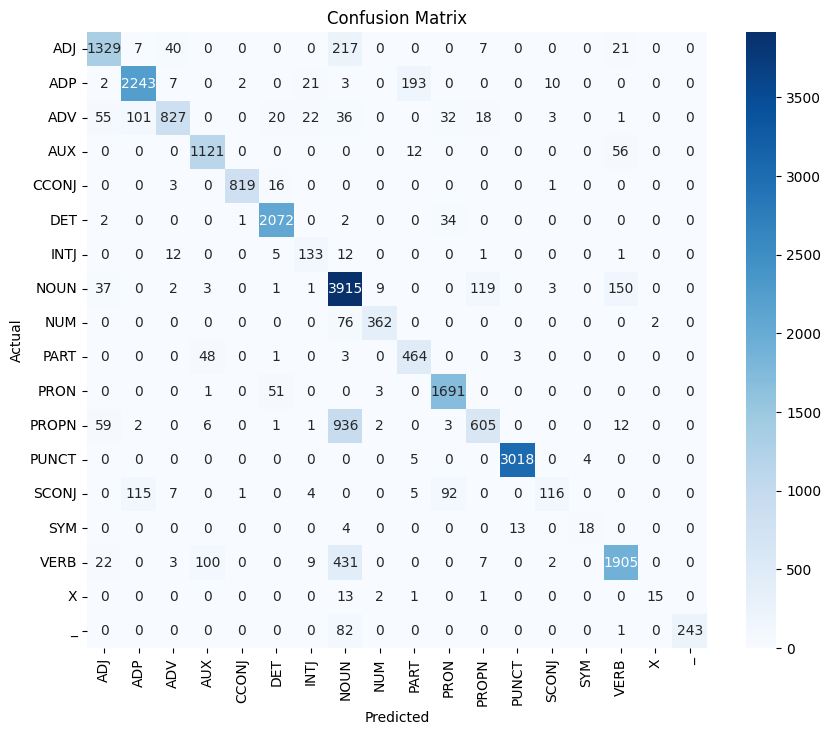

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(truelabs, predictedtags)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(set(truelabs)),
            yticklabels=sorted(set(truelabs)))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [11]:
# Step 1: Create a dictionary mapping words to their most frequent POS tag
word_to_pos = defaultdict(lambda: "NOUN")  # Default to NOUN for unknown words
pos_counts = defaultdict(Counter)  # Stores POS counts for each word

# Populate the dictionary using training data
for sentence, tags in zip(train_sentences, train_pos_tags):
    for word, tag in zip(sentence, tags):
        pos_counts[word][tag] += 1

# Assign the most frequent POS tag for each word
for word, counter in pos_counts.items():
    word_to_pos[word] = counter.most_common(1)[0][0]

# Define common suffixes and their corresponding POS tags
suffix_rules = {
    "ing": "VERB",  # Running -> Verb (Gerund)
    "ed": "VERB",   # Jumped -> Verb (Past Tense)
    "ly": "ADV",    # Quickly -> Adverb
    "s": "NOUN",    # Cats -> Plural Noun
    "es": "NOUN",   # Buses -> Plural Noun
    "ion": "NOUN",  # Revolution -> Noun
    "ment": "NOUN", # Development -> Noun
    "ive": "ADJ",   # Active -> Adjective
    "al": "ADJ",    # Logical -> Adjective
    "ous": "ADJ",   # Dangerous -> Adjective
    "ic": "ADJ",    # Artistic -> Adjective
}

# Define common prefixes and their corresponding POS tags
prefix_rules = {
    "un": "ADJ",   # Unhappy -> Adjective
    "re": "VERB",  # Rebuild -> Verb
    "pre": "ADJ",  # Prehistoric -> Adjective
    "dis": "ADJ",  # Disloyal -> Adjective
}

# Function to predict POS tags for a given sentence
def rule_based_tagger(sentence):
    predicted_tags = []
    
    for word in sentence:
        word_lower = word.lower()

        # 1. If the word is known, use its most frequent POS tag
        if word_lower in word_to_pos:
            predicted_tags.append(word_to_pos[word_lower])
            continue

        # 2. Check for suffix match
        for suffix, tag in suffix_rules.items():
            if word_lower.endswith(suffix):
                predicted_tags.append(tag)
                break
        else:
            # 3. Check for prefix match (if no suffix matched)
            for prefix, tag in prefix_rules.items():
                if word_lower.startswith(prefix):
                    predicted_tags.append(tag)
                    break
            else:
                # 4. Default to NOUN if no rule applies
                predicted_tags.append("NOUN")

    return predicted_tags

# Example: Predict on a sentence from the dev set
sample_sentence = dev_sentences[0]  # Take first dev sentence
predicted_tags = rule_based_tagger(sample_sentence)

print("\nSample Sentence:", sample_sentence)
print("Predicted POS Tags:", predicted_tags)

# Function to evaluate rule-based POS tagger
def evaluate_rule_based_tagger(sentences, true_pos_tags):
    correct = 0
    total = 0
    lisst=[]
    lissst=[]
    for sentence, true_tags in zip(sentences, true_pos_tags):
        predicted_tags = rule_based_tagger(sentence)
        lisst.extend(predicted_tags)
        lissst.extend(true_tags)
        # Compare predictions with ground truth
        for pred, true in zip(predicted_tags, true_tags):
            if pred == true:
                correct += 1
            total += 1

    accuracy = correct / total if total > 0 else 0
    # print(f"Rule-Based POS Tagger Accuracy: {accuracy:.2%}")
    print(f"Rule-Based POS Tagger(Prefix and suffix logic implemented) Accuracy: {accuracy:.2%}")
    return lisst, lissst

# Evaluate on dev set
predlabs,truelabs1=evaluate_rule_based_tagger(test_sentences,test_pos_tags)



Sample Sentence: ['introduction']
Predicted POS Tags: ['NOUN']
Rule-Based POS Tagger(Prefix and suffix logic implemented) Accuracy: 86.82%


In [12]:
print(classification_report(truelabs1,predlabs))

              precision    recall  f1-score   support

         ADJ       0.87      0.86      0.86      1621
         ADP       0.91      0.90      0.91      2481
         ADV       0.92      0.76      0.83      1115
         AUX       0.88      0.94      0.91      1189
       CCONJ       1.00      0.98      0.99       839
         DET       0.96      0.98      0.97      2111
        INTJ       0.70      0.81      0.75       164
        NOUN       0.72      0.91      0.81      4240
         NUM       0.96      0.82      0.89       440
        PART       0.68      0.89      0.77       519
        PRON       0.91      0.97      0.94      1746
       PROPN       0.80      0.37      0.51      1627
       PUNCT       0.99      1.00      1.00      3027
       SCONJ       0.86      0.34      0.49       340
         SYM       0.82      0.51      0.63        35
        VERB       0.87      0.84      0.86      2479
           X       0.88      0.47      0.61        32
           _       1.00    

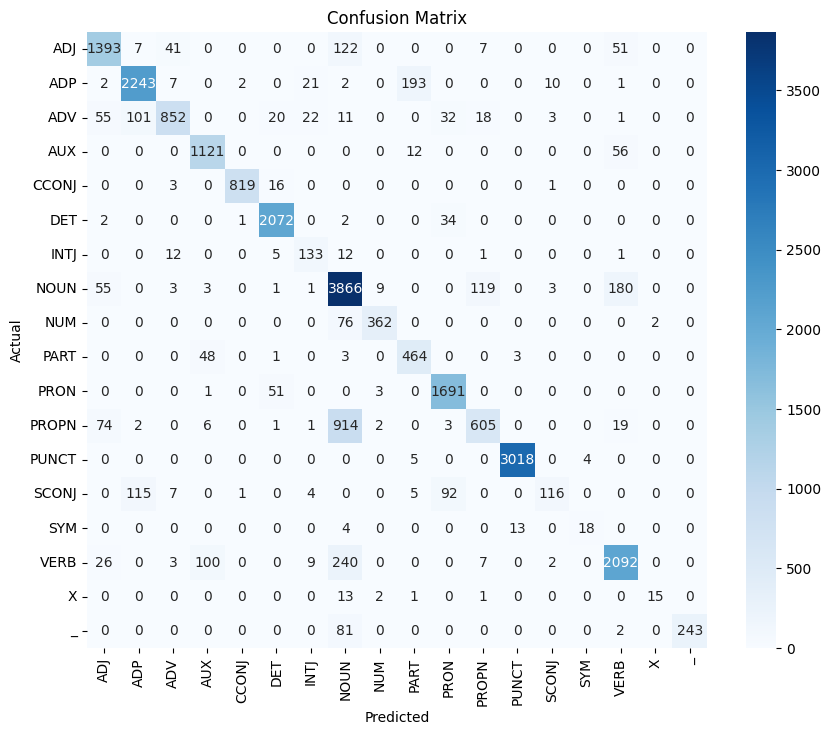

In [13]:
cm = confusion_matrix(truelabs1, predlabs)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(set(truelabs1)),
            yticklabels=sorted(set(truelabs1)))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [14]:
from collections import Counter

def analyze_errors(sentences, true_pos_tags):
    total_errors = 0
    error_details = []
    pos_error_counts = Counter()
    
    for sentence, true_tags in zip(sentences, true_pos_tags):
        predicted_tags = rule_based_tagger(sentence)
        
        for word, pred, true in zip(sentence, predicted_tags, true_tags):
            if pred != true:  # Error detected
                total_errors += 1
                pos_error_counts[true] += 1
                error_details.append((word, pred, true))
    
    # Display overall error count
    print(f"Total Errors: {total_errors}")
    
    # Display most common misclassified words
    print("\nTop 10 Most Misclassified Words:")
    for word, pred in Counter(error_details).most_common(10):
        print(f"Word: {word[0]} | Predicted: {word[1]} | True: {word[2]} | No. of times: {pred}")

    # Display which POS tags are misclassified the most
    print("\nMost Commonly Misclassified POS Tags:")
    for pos, count in pos_error_counts.most_common(10):
        print(f"POS: {pos} | Errors: {count}")

# Run analysis on dev set
analyze_errors(test_sentences,test_pos_tags)


Total Errors: 3208

Top 10 Most Misclassified Words:
Word: to | Predicted: PART | True: ADP | No. of times: 193
Word: that | Predicted: PRON | True: SCONJ | No. of times: 92
Word: have | Predicted: VERB | True: AUX | No. of times: 54
Word: 's | Predicted: AUX | True: PART | No. of times: 48
Word: this | Predicted: DET | True: PRON | No. of times: 38
Word: there | Predicted: PRON | True: ADV | No. of times: 29
Word: space | Predicted: NOUN | True: PROPN | No. of times: 29
Word: that | Predicted: PRON | True: DET | No. of times: 25
Word: eegimaa | Predicted: NOUN | True: PROPN | No. of times: 24
Word: as | Predicted: ADP | True: SCONJ | No. of times: 22

Most Commonly Misclassified POS Tags:
POS: PROPN | Errors: 1022
POS: VERB | Errors: 387
POS: NOUN | Errors: 374
POS: ADV | Errors: 263
POS: ADP | Errors: 238
POS: ADJ | Errors: 228
POS: SCONJ | Errors: 224
POS: _ | Errors: 83
POS: NUM | Errors: 78
POS: AUX | Errors: 68


    "to" (Predicted: PART | True: ADP, 183 times)
    Why is this wrong?
    "To" is ambiguous; it can be:
        A particle (PART): "I want to go home."
        A preposition (ADP): "Give it to her."
    The model likely defaults to "PART" because infinitives (to + verb) occur frequently in training data.



    "that" (Predicted: PRON | True: SCONJ, 106 times)
    Why is this wrong?
    "That" serves different roles:
        Pronoun (PRON): "I like that."
        Subordinating conjunction (SCONJ): "I know that he is coming."
    The model often classifies "that" as a pronoun because in isolation, it resembles a demonstrative pronoun.



    "'s" (Predicted: AUX | True: PART, 51 times)
    Why is this wrong?
    "'s" is ambiguous:
        Possessive particle (PART): "John's book."
        Auxiliary verb (AUX): "He's coming."
    The model overuses "AUX" because contractions like "he's" are frequent, while possessives occur less often.



    "have" (Predicted: VERB | True: AUX, 41 times)
    Why is this wrong?
    "Have" is used in two ways:
        Main verb (VERB): "I have a car."
        Auxiliary verb (AUX): "I have seen that movie."
    The model overpredicts "VERB" because "have" as a main verb is more frequent in training data.

    Why are verbs misclassified?
    Some auxiliary verbs (AUX) are wrongly tagged as main verbs (VERB). Example:
        "I do believe you." (AUX)
        "I do my work daily." (VERB)
    Some adjectives are misclassified as verbs:
        "I am interested in science." (ADJ, not VERB)

    Subordinating Conjunctions (SCONJ) – 260 errors
    Why are conjunctions hard to classify?
    Words like "that", "as", "because" can function as different POS tags depending on the sentence structure.
    Example:
        "I know that he is coming." (SCONJ)
        "I like that idea." (PRON)

    

    Analysis Result: The Tag of a word is decided based on the sentence structure and also on previous and further tags of words

# Statistical Machine Learning Approach for POS Tagging

    Implement data preprocessing and feature extraction.
    Train the CRF model and evaluate on a small dataset.
    Improve feature engineering for better accuracy.
    Conduct error analysis and compare with rule-based results.

#### Feature Extraction

In [15]:
def extract_features(sent, index):
    word = sent[index]
    
    # Basic features from the word
    features = {
        'word': word,
        'word.lower()': word.lower(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'word.len()': len(word),
    }
    
    # Prefixes and Suffixes
    features['prefix-2'] = word[:2]
    features['prefix-3'] = word[:3]
    features['suffix-2'] = word[-2:]
    features['suffix-3'] = word[-3:]
    
    # Previous word feature
    if index > 0:
        features['prev_word'] = sent[index - 1]
        features['prev_word.lower()'] = sent[index - 1].lower()
    else:
        features['prev_word'] = "<START>"
    
    # Next word feature
    if index < len(sent) - 1:
        features['next_word'] = sent[index + 1]
        features['next_word.lower()'] = sent[index + 1].lower()
    else:
        features['next_word'] = "<END>"
    
    # Remove previous/next POS tags as they depend on the training set
    # Alternatively, you could conditionally add these features only when available
    
    return features


# Example: Extract features for the first word in the first sentence of the training set
sample_sentence = train_sentences[0]
index = 0  # First word in the sentence
features = extract_features(sample_sentence, index)

print("Features for the first word in the first sentence:")
for feature, value in features.items():
    print(f"{feature}: {value}")


Features for the first word in the first sentence:
word: aesthetic
word.lower(): aesthetic
word.istitle(): False
word.isdigit(): False
word.len(): 9
prefix-2: ae
prefix-3: aes
suffix-2: ic
suffix-3: tic
prev_word: <START>
next_word: appreciation
next_word.lower(): appreciation


In [16]:
# Function to extract features for all words in a sentence
def extract_sentence_features(sent):
    sentence_features = []
    for index in range(len(sent)):
        features = extract_features(sent, index)
        sentence_features.append(features)
    return sentence_features

# Extract features for the first sentence in the training set
sentence_features = extract_sentence_features(train_sentences[0])
print("\nExtracted features for the first sentence:")
for i, features in enumerate(sentence_features):
    print(f"Word {i+1}:")
    for feature, value in features.items():
        print(f"  {feature}: {value}")



Extracted features for the first sentence:
Word 1:
  word: aesthetic
  word.lower(): aesthetic
  word.istitle(): False
  word.isdigit(): False
  word.len(): 9
  prefix-2: ae
  prefix-3: aes
  suffix-2: ic
  suffix-3: tic
  prev_word: <START>
  next_word: appreciation
  next_word.lower(): appreciation
Word 2:
  word: appreciation
  word.lower(): appreciation
  word.istitle(): False
  word.isdigit(): False
  word.len(): 12
  prefix-2: ap
  prefix-3: app
  suffix-2: on
  suffix-3: ion
  prev_word: aesthetic
  prev_word.lower(): aesthetic
  next_word: and
  next_word.lower(): and
Word 3:
  word: and
  word.lower(): and
  word.istitle(): False
  word.isdigit(): False
  word.len(): 3
  prefix-2: an
  prefix-3: and
  suffix-2: nd
  suffix-3: and
  prev_word: appreciation
  prev_word.lower(): appreciation
  next_word: spanish
  next_word.lower(): spanish
Word 4:
  word: spanish
  word.lower(): spanish
  word.istitle(): False
  word.isdigit(): False
  word.len(): 7
  prefix-2: sp
  prefix-3: s

In [17]:
from sklearn_crfsuite import CRF

# Function to extract features and labels from the dataset
def prepare_dataset(sentences, pos_tags):
    X = []  # Features
    y = []  # Labels (POS tags)
    
    for sent, tags in zip(sentences, pos_tags):
        sentence_features = extract_sentence_features(sent)
        X.append(sentence_features)
        y.append(tags)
    
    return X, y

# Prepare the training dataset
X_train, y_train = prepare_dataset(train_sentences, train_pos_tags)
X_dev, y_dev = prepare_dataset(dev_sentences, dev_pos_tags)
# Example: Show features and labels for the first sentence
# print("\nFeatures and Labels for the first sentence:")
# for features, label in zip(X_train[0], y_train[0]):
#     print(f"Features: {features}")
#     print(f"Label: {label}")
    


In [18]:
# Create and train the CRF model
crf = CRF(
    algorithm='lbfgs',  # Optimization algorithm
    c1=0.1,  # Regularization parameter
    c2=0.1,  # Regularization parameter
    max_iterations=100,  # Max iterations for optimization
    all_possible_transitions=True
)

# Train the model
crf.fit(X_train, y_train)


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    max_iterations=100)

In [19]:

# Example: Predict the POS tags for the first sentence in the dev set
print(dev_sentences[1])
sample_sentence = dev_sentences[1]
sentence_features = extract_sentence_features(sample_sentence)
predicted_tags = crf.predict([sentence_features])[0]

print("\nPredicted POS tags for the first sentence in the dev set:")
print(predicted_tags)
 

['research', 'on', 'adult', '-', 'learned', 'second', 'language', '(', 'l2', ')', 'has', 'provided', 'considerable', 'insight', 'into', 'the', 'neurocognitive', 'mechanisms', 'underlying', 'the', 'learning', 'and', 'processing', 'of', 'l2', 'grammar', '[', '1', ']', '–', '[', '11', ']', '.']

Predicted POS tags for the first sentence in the dev set:
['NOUN' 'ADP' 'NOUN' 'PUNCT' 'VERB' 'ADJ' 'NOUN' 'PUNCT' 'NOUN' 'PUNCT'
 'AUX' 'VERB' 'ADJ' 'NOUN' 'ADP' 'DET' 'ADJ' 'NOUN' 'VERB' 'DET' 'NOUN'
 'CCONJ' 'NOUN' 'ADP' 'NOUN' 'NOUN' 'PUNCT' 'NUM' 'PUNCT' 'PUNCT' 'PUNCT'
 'NUM' 'PUNCT' 'PUNCT']


In [20]:

from itertools import chain
from sklearn.metrics import accuracy_score, classification_report

def evaluate_crf_model_flat(crf, dev_sentences, dev_pos_tags):
    # Prepare the dev dataset (features and true labels)
    X_dev, y_dev = prepare_dataset(dev_sentences, dev_pos_tags)
    
    # Get predictions for each sentence
    y_pred = crf.predict(X_dev)
    
    # Flatten the lists of labels (one per sentence) into a single list
    y_dev_flat = list(chain(*y_dev))
    y_pred_flat = list(chain(*y_pred))
    
    # Calculate token-level accuracy
    accuracy = accuracy_score(y_dev_flat, y_pred_flat)
    print("Token-level Accuracy: {:.2%}".format(accuracy))
    
    # Print a classification report
    print("\nClassification Report:")
    print(classification_report(y_dev_flat, y_pred_flat))

# Evaluate the CRF model on the dev set using the new evaluation function
evaluate_crf_model_flat(crf, test_sentences,test_pos_tags)



Token-level Accuracy: 93.20%

Classification Report:
              precision    recall  f1-score   support

         ADJ       0.88      0.89      0.89      1621
         ADP       0.95      0.98      0.97      2481
         ADV       0.93      0.88      0.90      1115
         AUX       0.97      0.98      0.98      1189
       CCONJ       0.99      0.99      0.99       839
         DET       0.98      0.99      0.99      2111
        INTJ       0.91      0.85      0.88       164
        NOUN       0.86      0.92      0.89      4240
         NUM       0.98      0.96      0.97       440
        PART       0.96      0.96      0.96       519
        PRON       0.98      0.98      0.98      1746
       PROPN       0.79      0.67      0.73      1627
       PUNCT       1.00      1.00      1.00      3027
       SCONJ       0.84      0.76      0.80       340
         SYM       0.89      0.89      0.89        35
        VERB       0.95      0.93      0.94      2479
           X       0.70     

In [21]:
from sklearn_crfsuite import CRF
from sklearn.model_selection import GridSearchCV
from sklearn_crfsuite import metrics
best_score = 0
best_params = {}

for c1 in [0.01, 0.005, 0.1]:
    for c2 in [0.01, 0.005, 0.1]:
        for max_iter in [50, 100]:
            # Set up the CRF with current parameters
            crf = CRF(
                algorithm='lbfgs',
                c1=c1,
                c2=c2,
                max_iterations=max_iter,
                all_possible_transitions=True
            )
            
            # Train on the training set
            crf.fit(X_train, y_train)
            
            # Evaluate on the dev set
            y_pred = crf.predict(X_dev)
            score = metrics.flat_f1_score(y_dev, y_pred, average='weighted')
            print(f"c1: {c1}, c2: {c2}, max_iter: {max_iter}, Dev F1 Score: {score:.4f}")
            
            if score > best_score:
                best_score = score
                best_params = {'c1': c1, 'c2': c2, 'max_iterations': max_iter}

print("Best parameters based on dev set:", best_params)
print("Best Dev F1 Score:", best_score)






c1: 0.01, c2: 0.01, max_iter: 50, Dev F1 Score: 0.9397
c1: 0.01, c2: 0.01, max_iter: 100, Dev F1 Score: 0.9393
c1: 0.01, c2: 0.005, max_iter: 50, Dev F1 Score: 0.9405
c1: 0.01, c2: 0.005, max_iter: 100, Dev F1 Score: 0.9381
c1: 0.01, c2: 0.1, max_iter: 50, Dev F1 Score: 0.9433
c1: 0.01, c2: 0.1, max_iter: 100, Dev F1 Score: 0.9437
c1: 0.005, c2: 0.01, max_iter: 50, Dev F1 Score: 0.9393
c1: 0.005, c2: 0.01, max_iter: 100, Dev F1 Score: 0.9387
c1: 0.005, c2: 0.005, max_iter: 50, Dev F1 Score: 0.9394
c1: 0.005, c2: 0.005, max_iter: 100, Dev F1 Score: 0.9379
c1: 0.005, c2: 0.1, max_iter: 50, Dev F1 Score: 0.9416
c1: 0.005, c2: 0.1, max_iter: 100, Dev F1 Score: 0.9441
c1: 0.1, c2: 0.01, max_iter: 50, Dev F1 Score: 0.9424
c1: 0.1, c2: 0.01, max_iter: 100, Dev F1 Score: 0.9417
c1: 0.1, c2: 0.005, max_iter: 50, Dev F1 Score: 0.9426
c1: 0.1, c2: 0.005, max_iter: 100, Dev F1 Score: 0.9417
c1: 0.1, c2: 0.1, max_iter: 50, Dev F1 Score: 0.9430
c1: 0.1, c2: 0.1, max_iter: 100, Dev F1 Score: 0.9434
B

In [22]:
from itertools import chain

# Create and train the CRF model
crf = CRF(
    algorithm='lbfgs',  # Optimization algorithm
    c1=0.005,  # Regularization parameter
    c2=0.1,  # Regularization parameter
    max_iterations=100,  # Max iterations for optimization
    all_possible_transitions=True
)

# Train the model
crf.fit(X_train, y_train)

evaluate_crf_model_flat(crf, test_sentences,test_pos_tags)

Token-level Accuracy: 93.17%

Classification Report:
              precision    recall  f1-score   support

         ADJ       0.88      0.90      0.89      1621
         ADP       0.95      0.98      0.96      2481
         ADV       0.92      0.88      0.90      1115
         AUX       0.98      0.98      0.98      1189
       CCONJ       0.99      0.99      0.99       839
         DET       0.98      0.99      0.99      2111
        INTJ       0.90      0.84      0.87       164
        NOUN       0.86      0.93      0.89      4240
         NUM       0.98      0.97      0.97       440
        PART       0.96      0.97      0.97       519
        PRON       0.98      0.98      0.98      1746
       PROPN       0.80      0.66      0.73      1627
       PUNCT       1.00      1.00      1.00      3027
       SCONJ       0.83      0.75      0.79       340
         SYM       0.89      0.89      0.89        35
        VERB       0.95      0.93      0.94      2479
           X       0.78     

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchcrf import CRF
from torch.utils.data import Dataset, DataLoader
import numpy as np

# First install required package
total_train_loss=0
train_batches=0
# Define the Dataset class
class POSDataset(Dataset):
    def __init__(self, sentences, tags, word_vocab, tag_vocab):
        self.sentences = sentences
        self.tags = tags
        self.word_vocab = word_vocab
        self.tag_vocab = tag_vocab
        
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, idx):
        sentence = torch.tensor(self.sentences[idx], dtype=torch.long)
        tags = torch.tensor(self.tags[idx], dtype=torch.long)
        return sentence, tags

# Define the BiLSTM-CRF model
class BiLSTM_CRF(nn.Module):
    def __init__(self, vocab_size, tag_size, embedding_dim=128, hidden_dim=64):
        super(BiLSTM_CRF, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=word_vocab["<PAD>"])
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=2, bidirectional=True, batch_first=True)
        self.hidden2tag = nn.Linear(hidden_dim, tag_size)
        self.crf = CRF(tag_size, batch_first=True)
        
    def forward(self, x, tags=None, mask=None):
        # Get embeddings
        embeds = self.embedding(x)
        
        # LSTM layer
        lstm_out, _ = self.lstm(embeds)
        
        # Linear layer
        emissions = self.hidden2tag(lstm_out)
        
        # CRF layer
        if tags is not None:
            loss = -self.crf(emissions, tags, mask=mask, reduction='mean')
            return loss
        else:
            return self.crf.decode(emissions, mask=mask)

# Prepare datasets
def collate_fn(batch):
    sentences, tags = zip(*batch)
    lengths = torch.tensor([len(s) for s in sentences])
    
    # Pad sequences
    sentences_padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=word_vocab["<PAD>"])
    tags_padded = torch.nn.utils.rnn.pad_sequence(tags, batch_first=True, padding_value=pos_vocab["<PAD>"])
    
    # Create mask (1 for real tokens, 0 for padding)
    mask = (sentences_padded != word_vocab["<PAD>"]).bool()
    
    return sentences_padded, tags_padded, lengths, mask

# Create datasets and dataloaders
train_dataset = POSDataset(train_sentences_ids, train_pos_tags_ids, word_vocab, pos_vocab)
dev_dataset = POSDataset(dev_sentences_ids, dev_pos_tags_ids, word_vocab, pos_vocab)
test_dataset = POSDataset(test_sentences_ids, test_pos_tags_ids, word_vocab, pos_vocab)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Initialize model
device = torch.device("cpu")
model = BiLSTM_CRF(
    vocab_size=len(word_vocab),
    tag_size=len(pos_vocab),
    embedding_dim=128,
    hidden_dim=64
).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)
# Training loop
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for sentences, tags, lengths, mask in train_loader:
        try:
            # Move data to device
            sentences = sentences.to(device)
            tags = tags.to(device)
            mask = mask.to(device)
            
            # Forward pass
            loss = model(sentences, tags, mask)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping to prevent explosion
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            
            optimizer.step()
            
            total_train_loss += loss.item()
            train_batches += 1
            
        except RuntimeError as e:
            if 'CUDA' in str(e):
                print(f"CUDA Error: {e}")
                print("Falling back to CPU")
                device = torch.device("cpu")
                model = model.to(device)
            continue

    # Validation Phase
    model.eval()
    total_val_loss = 0
    val_batches = 0
    with torch.no_grad():
        for sentences, tags, lengths, mask in dev_loader:
            sentences = sentences.to(device)
            tags = tags.to(device)
            mask = mask.to(device)
            
            loss = model(sentences, tags, mask)
            total_val_loss += loss.item()
            val_batches += 1

    # Calculate epoch metrics
    avg_train_loss = total_train_loss / train_batches
    avg_val_loss = total_val_loss / val_batches
    
    # Update learning rate
    scheduler.step(avg_val_loss)
    
    # Print statistics
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

# Evaluation function
def evaluate(model, dataloader):
    model.eval()
    total_correct = 0
    total_tags = 0
    
    with torch.no_grad():
        for sentences, tags, lengths, mask in dataloader:
            sentences = sentences.to(device)
            tags = tags.to(device)
            mask = mask.to(device)
            
            # Get predictions
            predictions = model(sentences, mask=mask)
            
            # Flatten predictions and tags
            tags_flat = tags[mask].cpu().numpy()
            preds_flat = np.concatenate(predictions)
            
            # Calculate accuracy
            total_correct += (preds_flat == tags_flat).sum()
            total_tags += len(tags_flat)
    
    return total_correct / total_tags

# Test evaluation
test_accuracy = evaluate(model, test_loader)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Prediction function
def predict_pos(sentence, model, word_vocab, pos_vocab, device='cpu'):
    # Convert to IDs
    id_to_tag = {v: k for k, v in pos_vocab.items()}
    tokens = [word.lower() for word in sentence]
    token_ids = [word_vocab.get(token, word_vocab["<UNK>"]) for token in tokens]
    
    # Convert to tensor
    input_tensor = torch.tensor([token_ids], dtype=torch.long).to(device)
    
    # Create mask
    mask = torch.ones_like(input_tensor).bool().to(device)
    
    # Predict
    model.eval()
    with torch.no_grad():
        tag_ids = model(input_tensor, mask=mask)[0]
    
    # Convert to tags
    return list(zip(tokens, [id_to_tag[id] for id in tag_ids]))

# Example usage
sample_sentence = ["The", "quick", "brown", "fox", "jumps", "over", "the", "lazy", "dog", "."]
predicted = predict_pos(sample_sentence, model, word_vocab, pos_vocab, device)
print("\nPredicted POS tags:")
for token, tag in predicted:
    print(f"{token:>10} : {tag}")


Epoch 1/15
Train Loss: 9.4837 | Val Loss: 4.6923
Learning Rate: 0.010000

Epoch 2/15
Train Loss: 6.2296 | Val Loss: 4.2465
Learning Rate: 0.010000

Epoch 3/15
Train Loss: 4.7182 | Val Loss: 4.7368
Learning Rate: 0.010000

Epoch 4/15
Train Loss: 3.8198 | Val Loss: 5.1533
Learning Rate: 0.010000

Epoch 5/15
Train Loss: 3.2297 | Val Loss: 5.2186
Learning Rate: 0.005000

Epoch 6/15
Train Loss: 2.7774 | Val Loss: 5.7387
Learning Rate: 0.005000

Epoch 7/15
Train Loss: 2.4160 | Val Loss: 6.4213
Learning Rate: 0.005000

Epoch 8/15
Train Loss: 2.1319 | Val Loss: 6.8380
Learning Rate: 0.002500

Epoch 9/15
Train Loss: 1.9042 | Val Loss: 6.8764
Learning Rate: 0.002500

Epoch 10/15
Train Loss: 1.7197 | Val Loss: 7.0330
Learning Rate: 0.002500

Epoch 11/15
Train Loss: 1.5676 | Val Loss: 7.3567
Learning Rate: 0.001250

Epoch 12/15
Train Loss: 1.4400 | Val Loss: 7.3848
Learning Rate: 0.001250

Epoch 13/15
Train Loss: 1.3317 | Val Loss: 7.4692
Learning Rate: 0.001250

Epoch 14/15
Train Loss: 1.2386 | 

In [25]:
# Add this code after your training loop is complete

# Evaluation on training set
train_accuracy = evaluate(model, train_loader)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# If you want more detailed metrics for the training set:
def detailed_evaluation(model, dataloader, id_to_tag):
    model.eval()
    all_predictions = []
    all_true_tags = []
    
    with torch.no_grad():
        for sentences, tags, lengths, mask in dataloader:
            sentences = sentences.to(device)
            tags = tags.to(device)
            mask = mask.to(device)
            
            # Get predictions
            predictions = model(sentences, mask=mask)
            
            # For each sentence in the batch
            for i, (pred, true, m) in enumerate(zip(predictions, tags, mask)):
                # Only consider positions where mask is True
                sentence_mask = m.cpu().numpy()
                true_tags = tags[i][sentence_mask].cpu().numpy()
                
                # Append to lists
                all_predictions.extend(pred)
                all_true_tags.extend(true_tags)
    
    # Calculate metrics
    correct = sum(p == t for p, t in zip(all_predictions, all_true_tags))
    total = len(all_predictions)
    accuracy = correct / total if total > 0 else 0
    
    # Print per-tag accuracy if needed
    if id_to_tag:
        print("\nPer-tag accuracy:")
        tag_correct = {}
        tag_total = {}
        
        for pred, true in zip(all_predictions, all_true_tags):
            true_tag = id_to_tag[true]
            tag_total[true_tag] = tag_total.get(true_tag, 0) + 1
            if pred == true:
                tag_correct[true_tag] = tag_correct.get(true_tag, 0) + 1
        
        for tag in sorted(tag_total.keys()):
            tag_acc = tag_correct.get(tag, 0) / tag_total[tag]
            print(f"{tag:>10}: {tag_acc:.4f} ({tag_correct.get(tag, 0)}/{tag_total[tag]})")
    
    return accuracy

# Create id_to_tag mapping
id_to_tag = {v: k for k, v in pos_vocab.items()}

# Perform detailed evaluation on training set
print("\nDetailed evaluation on training set:")
detailed_train_accuracy = detailed_evaluation(model, train_loader, id_to_tag)
print(f"\nOverall Training Accuracy: {detailed_train_accuracy:.4f}")

# Optional: Compare with test set detailed metrics
print("\nDetailed evaluation on test set:")
detailed_test_accuracy = detailed_evaluation(model, test_loader, id_to_tag)
print(f"\nOverall Test Accuracy: {detailed_test_accuracy:.4f}")

Training Accuracy: 0.9999
Test Accuracy: 0.9058

Detailed evaluation on training set:

Per-tag accuracy:
       ADJ: 0.9996 (10760/10764)
       ADP: 1.0000 (15476/15476)
       ADV: 0.9997 (7837/7839)
       AUX: 1.0000 (8821/8821)
     CCONJ: 1.0000 (5390/5390)
       DET: 1.0000 (13328/13328)
      INTJ: 0.9950 (1595/1603)
      NOUN: 1.0000 (27288/27288)
       NUM: 0.9997 (3169/3170)
      PART: 1.0000 (3934/3934)
      PRON: 0.9999 (13797/13798)
     PROPN: 0.9999 (9527/9528)
     PUNCT: 1.0000 (22748/22748)
     SCONJ: 0.9996 (2647/2648)
       SYM: 1.0000 (267/267)
      VERB: 1.0000 (17189/17189)
         X: 0.9968 (316/317)
         _: 1.0000 (2810/2810)

Overall Training Accuracy: 0.9999

Detailed evaluation on test set:

Per-tag accuracy:
       ADJ: 0.9112 (1477/1621)
       ADP: 0.9605 (2383/2481)
       ADV: 0.8619 (961/1115)
       AUX: 0.9748 (1159/1189)
     CCONJ: 0.9928 (833/839)
       DET: 0.9929 (2096/2111)
      INTJ: 0.8354 (137/164)
      NOUN: 0.8458 (3586/42

In [27]:
# Add this code after your training loop is complete

# Evaluation on training set
train_accuracy = evaluate(model, train_loader)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# If you want more detailed metrics for the training set:
def detailed_evaluation(model, dataloader, id_to_tag):
    model.eval()
    all_predictions = []
    all_true_tags = []
    
    with torch.no_grad():
        for sentences, tags, lengths, mask in dataloader:
            sentences = sentences.to(device)
            tags = tags.to(device)
            mask = mask.to(device)
            
            # Get predictions
            predictions = model(sentences, mask=mask)
            
            # For each sentence in the batch
            for i, (pred, true, m) in enumerate(zip(predictions, tags, mask)):
                # Only consider positions where mask is True
                sentence_mask = m.cpu().numpy()
                true_tags = tags[i][sentence_mask].cpu().numpy()
                
                # Append to lists
                all_predictions.extend(pred)
                all_true_tags.extend(true_tags)
    
    # Calculate metrics
    correct = sum(p == t for p, t in zip(all_predictions, all_true_tags))
    total = len(all_predictions)
    accuracy = correct / total if total > 0 else 0
    
    # Print per-tag accuracy if needed
    if id_to_tag:
        print("\nPer-tag accuracy:")
        tag_correct = {}
        tag_total = {}
        
        for pred, true in zip(all_predictions, all_true_tags):
            true_tag = id_to_tag[true]
            tag_total[true_tag] = tag_total.get(true_tag, 0) + 1
            if pred == true:
                tag_correct[true_tag] = tag_correct.get(true_tag, 0) + 1
        
        for tag in sorted(tag_total.keys()):
            tag_acc = tag_correct.get(tag, 0) / tag_total[tag]
            print(f"{tag:>10}: {tag_acc:.4f} ({tag_correct.get(tag, 0)}/{tag_total[tag]})")
    
    return accuracy

# Create id_to_tag mapping
id_to_tag = {v: k for k, v in pos_vocab.items()}

# Perform detailed evaluation on training set
print("\nDetailed evaluation on training set:")
detailed_train_accuracy = detailed_evaluation(model, train_loader, id_to_tag)
print(f"\nOverall Training Accuracy: {detailed_train_accuracy:.4f}")

# Optional: Compare with test set detailed metrics
print("\nDetailed evaluation on test set:")
detailed_test_accuracy = detailed_evaluation(model, test_loader, id_to_tag)
print(f"\nOverall Test Accuracy: {detailed_test_accuracy:.4f}")

Training Accuracy: 0.9999
Test Accuracy: 0.9058

Detailed evaluation on training set:

Per-tag accuracy:
       ADJ: 0.9996 (10760/10764)
       ADP: 1.0000 (15476/15476)
       ADV: 0.9997 (7837/7839)
       AUX: 1.0000 (8821/8821)
     CCONJ: 1.0000 (5390/5390)
       DET: 1.0000 (13328/13328)
      INTJ: 0.9950 (1595/1603)
      NOUN: 1.0000 (27288/27288)
       NUM: 0.9997 (3169/3170)
      PART: 1.0000 (3934/3934)
      PRON: 0.9999 (13797/13798)
     PROPN: 0.9999 (9527/9528)
     PUNCT: 1.0000 (22748/22748)
     SCONJ: 0.9996 (2647/2648)
       SYM: 1.0000 (267/267)
      VERB: 1.0000 (17189/17189)
         X: 0.9968 (316/317)
         _: 1.0000 (2810/2810)

Overall Training Accuracy: 0.9999

Detailed evaluation on test set:

Per-tag accuracy:
       ADJ: 0.9112 (1477/1621)
       ADP: 0.9605 (2383/2481)
       ADV: 0.8619 (961/1115)
       AUX: 0.9748 (1159/1189)
     CCONJ: 0.9928 (833/839)
       DET: 0.9929 (2096/2111)
      INTJ: 0.8354 (137/164)
      NOUN: 0.8458 (3586/42

## BiLSTM-CRF Model

In [28]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import conllu
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.models import Model
from collections import defaultdict
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ------------------------------------------------------------------
# ORIGINAL PREPROCESSING CODE
# ------------------------------------------------------------------
# Function to load and parse a CoNLL-U file
def load_conllu_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = conllu.parse(f.read())
    return data

# Load the train, dev, and test files (update the file paths as needed)
train_data = load_conllu_data('UD_English-GUM/en_gum-ud-train.conllu')
dev_data = load_conllu_data('UD_English-GUM/en_gum-ud-dev.conllu')
test_data = load_conllu_data('UD_English-GUM/en_gum-ud-test.conllu')

# Function to extract sentences and POS tags
def extract_sentences_and_tags(data):
    sentences = []
    pos_tags = []
    for sentence in data:
        words = [token['form'].lower() for token in sentence]  # Convert to lowercase
        tags = [token['upostag'] for token in sentence]
        sentences.append(words)
        pos_tags.append(tags)
    return sentences, pos_tags

# Extract words and POS tags from each dataset
train_sentences, train_pos_tags = extract_sentences_and_tags(train_data)
dev_sentences, dev_pos_tags = extract_sentences_and_tags(dev_data)
test_sentences, test_pos_tags = extract_sentences_and_tags(test_data)

# Build word vocabulary with an <UNK> token
word_vocab = defaultdict(lambda: len(word_vocab))  # Automatically assigns unique IDs
word_vocab["<PAD>"] = 0  # Padding token
word_vocab["<UNK>"] = 1  # Unknown words

# Build POS vocabulary
pos_vocab = defaultdict(lambda: len(pos_vocab))  # Automatically assigns unique IDs
pos_vocab["<PAD>"] = 0  # Padding token

# Populate vocabularies using training data only
for sentence, tags in zip(train_sentences, train_pos_tags):
    for word in sentence:
        _ = word_vocab[word]  # Assign ID if not already present
    for tag in tags:
        _ = pos_vocab[tag]  # Assign ID if not already present

# Convert words and POS tags to IDs
def convert_to_ids(sentences, pos_tags, word_vocab, pos_vocab):
    encoded_sentences = [[word_vocab.get(word, word_vocab["<UNK>"]) for word in sent] for sent in sentences]
    encoded_pos_tags = [[pos_vocab[tag] for tag in tags] for tags in pos_tags]
    return encoded_sentences, encoded_pos_tags

# Convert datasets to numerical form
train_sentences_ids, train_pos_tags_ids = convert_to_ids(train_sentences, train_pos_tags, word_vocab, pos_vocab)
dev_sentences_ids, dev_pos_tags_ids = convert_to_ids(dev_sentences, dev_pos_tags, word_vocab, pos_vocab)
test_sentences_ids, test_pos_tags_ids = convert_to_ids(test_sentences, test_pos_tags, word_vocab, pos_vocab)

# Define maximum sequence length (you can set this as needed; consider the typical sentence lengths in your data)
MAX_LEN = 100

# Pad the sequences to ensure consistent length
train_sentences_ids = pad_sequences(train_sentences_ids, maxlen=MAX_LEN, padding='post', truncating='post', value=word_vocab["<PAD>"])
train_pos_tags_ids = pad_sequences(train_pos_tags_ids, maxlen=MAX_LEN, padding='post', truncating='post', value=pos_vocab["<PAD>"])
dev_sentences_ids = pad_sequences(dev_sentences_ids, maxlen=MAX_LEN, padding='post', truncating='post', value=word_vocab["<PAD>"])
dev_pos_tags_ids = pad_sequences(dev_pos_tags_ids, maxlen=MAX_LEN, padding='post', truncating='post', value=pos_vocab["<PAD>"])
test_sentences_ids = pad_sequences(test_sentences_ids, maxlen=MAX_LEN, padding='post', truncating='post', value=word_vocab["<PAD>"])
test_pos_tags_ids = pad_sequences(test_pos_tags_ids, maxlen=MAX_LEN, padding='post', truncating='post', value=pos_vocab["<PAD>"])

# Update hyperparameters using the vocabularies you just built
VOCAB_SIZE = len(word_vocab)    # Vocabulary size from actual data
TAG_SIZE = len(pos_vocab)        # Number of unique POS tags
EMBEDDING_DIM = 128              # Can remain the same or be adjusted
LSTM_UNITS = 64                  # Number of LSTM units

# ------------------------------------------------------------------
# MODEL DEFINITION (BiLSTM-CRF)
# ------------------------------------------------------------------
class BiLSTM_CRF(Model):
    def __init__(self, vocab_size, tag_size, embedding_dim, lstm_units):
        super(BiLSTM_CRF, self).__init__()
        # Embedding layer with masking for PAD tokens (<PAD> index is 0)
        self.embedding = Embedding(vocab_size, embedding_dim, mask_zero=True)
        # Bidirectional LSTM for contextual features
        self.bilstm = Bidirectional(LSTM(lstm_units, return_sequences=True))
        # Dense layer to project to tag logits
        self.dense = Dense(tag_size)
        # Transition parameters for CRF layer
        self.transition_params = tf.Variable(
            tf.random.uniform(shape=(tag_size, tag_size)),
            trainable=True
        )
        self.tag_size = tag_size
        
    def call(self, inputs, labels=None, training=None):
        # Forward pass through embedding and BiLSTM layers
        x = self.embedding(inputs)   # (batch, seq_len, embedding_dim)
        x = self.bilstm(x)           # (batch, seq_len, 2*lstm_units)
        logits = self.dense(x)       # (batch, seq_len, tag_size)
        
        # Create a mask (assume PAD token index is 0)
        mask = tf.cast(tf.math.not_equal(inputs, 0), tf.bool)
        sequence_lengths = tf.reduce_sum(tf.cast(mask, tf.int32), axis=1)
        
        if labels is not None:
            # Training branch: calculate the CRF loss
            log_likelihood, _ = tfa.text.crf_log_likelihood(
                logits, 
                labels, 
                sequence_lengths,
                transition_params=self.transition_params
            )
            return -tf.reduce_mean(log_likelihood)
        else:
            # Inference branch: decode the best tag sequence
            decoded_sequence, _ = tfa.text.crf_decode(
                logits, 
                self.transition_params, 
                sequence_lengths
            )
            return decoded_sequence

# ------------------------------------------------------------------
# INSTANTIATE AND BUILD THE MODEL
# ------------------------------------------------------------------
model = BiLSTM_CRF(VOCAB_SIZE, TAG_SIZE, EMBEDDING_DIM, LSTM_UNITS)

# Force a dummy call to build all internal variables
dummy_inputs = np.zeros((1, MAX_LEN), dtype=np.int32)
dummy_labels = np.zeros((1, MAX_LEN), dtype=np.int32)
_ = model(dummy_inputs, labels=dummy_labels)

# Optionally build the model fully and print summary.
model.build(input_shape=(None, MAX_LEN))
model.summary()

# ------------------------------------------------------------------
# TRAINING SETUP
# ------------------------------------------------------------------
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        loss = model(inputs, labels=labels, training=True)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

EPOCHS = 10
BATCH_SIZE = 32

train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences_ids, train_pos_tags_ids)).shuffle(1000).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences_ids, test_pos_tags_ids)).batch(BATCH_SIZE)
dev_dataset = tf.data.Dataset.from_tensor_slices((dev_sentences_ids, dev_pos_tags_ids)).batch(BATCH_SIZE)

# Training loop
for epoch in range(EPOCHS):
    epoch_loss = 0.0
    steps = 0
    for batch_inputs, batch_labels in train_dataset:
        loss = train_step(batch_inputs, batch_labels)
        epoch_loss += loss.numpy()
        steps += 1
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss/steps:.4f}")

# ------------------------------------------------------------------
# EVALUATION ON THE DEVELOPMENT SET
# ------------------------------------------------------------------
def evaluate_model(model, dataset):
    predictions = []
    true_labels = []
    for batch_inputs, batch_labels in dataset:
        preds = model(batch_inputs)  # Inference mode
        predictions.extend(preds.numpy().tolist())
        true_labels.extend(batch_labels.numpy().tolist())
    return predictions, true_labels

dev_predictions, dev_true = evaluate_model(model, test_dataset)

print("\nSample Prediction on Dev Set:")
print("Predicted tags (first sentence):", dev_predictions[0])
print("True tags (first sentence):     ", dev_true[0])


Model: "bi_lstm_crf_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     multiple                  1991296   
                                                                 
 bidirectional_1 (Bidirectio  multiple                 98816     
 nal)                                                            
                                                                 
 dense_1 (Dense)             multiple                  2451      
                                                                 
Total params: 2,092,924
Trainable params: 2,092,924
Non-trainable params: 0
_________________________________________________________________


2025-04-26 16:34:20.218395: W tensorflow/core/common_runtime/forward_type_inference.cc:332] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}

	while inferring type of node 'bi_lstm_crf_1/cond/output/_11'
2025-04-26 16:34:20.424587: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: bi_lstm_crf_1/cond_1/branch_executed/_40
2025-04-26 16:34:41.007781: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input:

Epoch 1/10, Loss: 21.4740
Epoch 2/10, Loss: 3.9929
Epoch 3/10, Loss: 2.1261
Epoch 4/10, Loss: 1.4844
Epoch 5/10, Loss: 1.1121
Epoch 6/10, Loss: 0.8413
Epoch 7/10, Loss: 0.6419
Epoch 8/10, Loss: 0.4778
Epoch 9/10, Loss: 0.3629
Epoch 10/10, Loss: 0.2820

Sample Prediction on Dev Set:
Predicted tags (first sentence): [10, 2, 5, 7, 5, 1, 2, 5, 1, 6, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True tags (first sentence):      [10, 2, 5, 2, 5, 1, 2, 5, 1, 6, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [29]:
def evaluatemodel(model, dataset, idx2tag=None):
    """
    Evaluate the BiLSTM-CRF model on a dataset.
    
    Args:
        model: The trained BiLSTM-CRF model
        dataset: TensorFlow dataset containing input sequences and their true labels
        idx2tag: Optional dictionary mapping from tag indices to tag names
                (if provided, results will include tag names instead of indices)
    
    Returns:
        Dictionary with various evaluation metrics
    """
    all_predictions = []
    all_true_labels = []
    
    # Get predictions for all batches
    for batch_inputs, batch_labels in dataset:
        # Inference mode: no labels passed so that decoding is used
        preds = model(batch_inputs)
        
        # Convert to numpy arrays for easier manipulation
        preds_np = preds.numpy()
        labels_np = batch_labels.numpy()
        
        # Create mask for padding (assuming PAD token index is 0)
        mask = (batch_inputs.numpy() != 0)
        
        # Apply mask to predictions and true labels
        for i in range(len(preds_np)):
            # Extract valid (non-padded) predictions and labels for this sequence
            valid_length = np.sum(mask[i])
            valid_preds = preds_np[i][:valid_length]
            valid_labels = labels_np[i][:valid_length]
            
            all_predictions.append(valid_preds)
            all_true_labels.append(valid_labels)
    
    # Calculate overall token-level accuracy
    correct = 0
    total = 0
    for pred_seq, true_seq in zip(all_predictions, all_true_labels):
        correct += np.sum(pred_seq == true_seq)
        total += len(true_seq)
    
    accuracy = correct / total if total > 0 else 0
    
    # Calculate per-tag precision, recall, and F1 score
    # First, get all unique tags (excluding PAD)
    all_tags = set()
    for labels in all_true_labels:
        all_tags.update(labels)
    if 0 in all_tags:  # Remove PAD tag
        all_tags.remove(0)
    
    tag_metrics = {}
    for tag in all_tags:
        true_positives = 0
        false_positives = 0
        false_negatives = 0
        
        for pred_seq, true_seq in zip(all_predictions, all_true_labels):
            # True positives: predicted tag matches true tag
            true_positives += np.sum((pred_seq == tag) & (true_seq == tag))
            # False positives: predicted tag but true tag is different
            false_positives += np.sum((pred_seq == tag) & (true_seq != tag))
            # False negatives: true tag but predicted tag is different
            false_negatives += np.sum((pred_seq != tag) & (true_seq == tag))
        
        # Calculate precision, recall, and F1 score
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        tag_name = idx2tag[tag] if idx2tag else str(tag)
        tag_metrics[tag_name] = {
            'precision': precision,
            'recall': recall,
            'f1': f1
        }
    
    # Calculate macro-average F1 score
    macro_f1 = sum(metrics['f1'] for metrics in tag_metrics.values()) / len(tag_metrics) if tag_metrics else 0
    
    # Sample predictions for display
    num_samples = min(5, len(all_predictions))
    samples = []
    for i in range(num_samples):
        pred_tags = all_predictions[i]
        true_tags = all_true_labels[i]
        
        if idx2tag:
            pred_tags = [idx2tag[int(idx)] for idx in pred_tags]
            true_tags = [idx2tag[int(idx)] for idx in true_tags]
        
        samples.append({
            'predicted': pred_tags,
            'true': true_tags
        })
    
    return {
        'accuracy': accuracy,
        'macro_f1': macro_f1,
        'tag_metrics': tag_metrics,
        'samples': samples
    }

# Example usage for your code
# Create a mapping from indices to tag names
idx2tag = {v: k for k, v in pos_vocab.items()}

# Evaluate the model
eval_results = evaluatemodel(model, dev_dataset, idx2tag)

# Print evaluation results
print("\n===== MODEL EVALUATION =====")
print(f"Overall Accuracy: {eval_results['accuracy']:.4f}")
print(f"Macro-Average F1 Score: {eval_results['macro_f1']:.4f}")

print("\nPer-Tag Metrics:")
for tag, metrics in eval_results['tag_metrics'].items():
    print(f"  {tag}:")
    print(f"    Precision: {metrics['precision']:.4f}")
    print(f"    Recall: {metrics['recall']:.4f}")
    print(f"    F1 Score: {metrics['f1']:.4f}")

print("\nSample Predictions:")
for i, sample in enumerate(eval_results['samples']):
    print(f"\nSample {i+1}:")
    print(f"  Predicted: {sample['predicted']}")
    print(f"  True:      {sample['true']}")


===== MODEL EVALUATION =====
Overall Accuracy: 0.9248
Macro-Average F1 Score: 0.8670

Per-Tag Metrics:
  ADJ:
    Precision: 0.8676
    Recall: 0.8605
    F1 Score: 0.8640
  NOUN:
    Precision: 0.8610
    Recall: 0.9074
    F1 Score: 0.8836
  CCONJ:
    Precision: 0.9904
    Recall: 0.9940
    F1 Score: 0.9922
  PUNCT:
    Precision: 0.9969
    Recall: 0.9997
    F1 Score: 0.9983
  ADP:
    Precision: 0.9464
    Recall: 0.9596
    F1 Score: 0.9529
  PROPN:
    Precision: 0.7065
    Recall: 0.5520
    F1 Score: 0.6197
  VERB:
    Precision: 0.8989
    Recall: 0.9141
    F1 Score: 0.9064
  ADV:
    Precision: 0.8938
    Recall: 0.8704
    F1 Score: 0.8819
  AUX:
    Precision: 0.9786
    Recall: 0.9786
    F1 Score: 0.9786
  DET:
    Precision: 0.9920
    Recall: 0.9821
    F1 Score: 0.9870
  PRON:
    Precision: 0.9838
    Recall: 0.9855
    F1 Score: 0.9847
  SCONJ:
    Precision: 0.8180
    Recall: 0.8099
    F1 Score: 0.8139
  X:
    Precision: 0.1538
    Recall: 0.5000
    F1 Scor

In [30]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import conllu
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from collections import defaultdict
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import KFold

# ------------------------------------------------------------------
# ORIGINAL PREPROCESSING CODE
# ------------------------------------------------------------------
def load_conllu_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = conllu.parse(f.read())
    return data

# Update the file paths as needed.
train_data = load_conllu_data('UD_English-GUM/en_gum-ud-train.conllu')
dev_data   = load_conllu_data('UD_English-GUM/en_gum-ud-dev.conllu')
test_data  = load_conllu_data('UD_English-GUM/en_gum-ud-test.conllu')

def extract_sentences_and_tags(data):
    sentences, pos_tags = [], []
    for sentence in data:
        words = [token['form'].lower() for token in sentence]
        tags  = [token['upostag'] for token in sentence]
        sentences.append(words)
        pos_tags.append(tags)
    return sentences, pos_tags

train_sentences, train_pos_tags = extract_sentences_and_tags(train_data)
dev_sentences, dev_pos_tags     = extract_sentences_and_tags(dev_data)
test_sentences, test_pos_tags   = extract_sentences_and_tags(test_data)

# Build vocabularies using training data only.
word_vocab = defaultdict(lambda: len(word_vocab))
word_vocab["<PAD>"] = 0
word_vocab["<UNK>"] = 1

pos_vocab = defaultdict(lambda: len(pos_vocab))
pos_vocab["<PAD>"] = 0

for sentence, tags in zip(train_sentences, train_pos_tags):
    for word in sentence:
        _ = word_vocab[word]
    for tag in tags:
        _ = pos_vocab[tag]

def convert_to_ids(sentences, pos_tags, word_vocab, pos_vocab):
    encoded_sentences = [
        [word_vocab.get(word, word_vocab["<UNK>"]) for word in sent]
        for sent in sentences
    ]
    encoded_pos_tags = [
        [pos_vocab[tag] for tag in tags] for tags in pos_tags
    ]
    return encoded_sentences, encoded_pos_tags

train_sentences_ids, train_pos_tags_ids = convert_to_ids(train_sentences, train_pos_tags, word_vocab, pos_vocab)
dev_sentences_ids, dev_pos_tags_ids     = convert_to_ids(dev_sentences, dev_pos_tags, word_vocab, pos_vocab)
test_sentences_ids, test_pos_tags_ids     = convert_to_ids(test_sentences, test_pos_tags, word_vocab, pos_vocab)

# Set maximum sequence length and pad sequences.
MAX_LEN = 100
train_sentences_ids = pad_sequences(train_sentences_ids, maxlen=MAX_LEN, padding='post', truncating='post', value=word_vocab["<PAD>"])
train_pos_tags_ids  = pad_sequences(train_pos_tags_ids, maxlen=MAX_LEN, padding='post', truncating='post', value=pos_vocab["<PAD>"])
dev_sentences_ids   = pad_sequences(dev_sentences_ids, maxlen=MAX_LEN, padding='post', truncating='post', value=word_vocab["<PAD>"])
dev_pos_tags_ids    = pad_sequences(dev_pos_tags_ids, maxlen=MAX_LEN, padding='post', truncating='post', value=pos_vocab["<PAD>"])
test_sentences_ids  = pad_sequences(test_sentences_ids, maxlen=MAX_LEN, padding='post', truncating='post', value=word_vocab["<PAD>"])
test_pos_tags_ids   = pad_sequences(test_pos_tags_ids, maxlen=MAX_LEN, padding='post', truncating='post', value=pos_vocab["<PAD>"])

VOCAB_SIZE    = len(word_vocab)
TAG_SIZE      = len(pos_vocab)
EMBEDDING_DIM = 128
LSTM_UNITS    = 64

# ------------------------------------------------------------------
# MODEL DEFINITION (BiLSTM-CRF with Additional Layers)
# ------------------------------------------------------------------
class BiLSTM_CRF(Model):
    def __init__(self, vocab_size, tag_size, embedding_dim, lstm_units, dropout_rate=0.5):
        super(BiLSTM_CRF, self).__init__()
        self.embedding = Embedding(vocab_size, embedding_dim, mask_zero=True)
        self.bilstm    = Bidirectional(LSTM(lstm_units, return_sequences=True))
        self.dropout   = Dropout(dropout_rate)
        # Intermediate Dense layer with ReLU activation.
        self.intermediate_dense = Dense(lstm_units, activation='relu')
        # Final Dense layer to project to tag logits.
        self.dense     = Dense(tag_size)
        # CRF transition parameters.
        self.transition_params = tf.Variable(
            tf.random.uniform(shape=(tag_size, tag_size)),
            trainable=True
        )
        self.tag_size = tag_size

    def call(self, inputs, labels=None, training=None):
        x = self.embedding(inputs)         # (batch, seq_len, embedding_dim)
        x = self.bilstm(x)                 # (batch, seq_len, 2*lstm_units)
        x = self.dropout(x, training=training)  # Apply dropout if training.
        x = self.intermediate_dense(x)     # (batch, seq_len, lstm_units)
        logits = self.dense(x)             # (batch, seq_len, tag_size)

        # Create mask assuming PAD token index is 0.
        mask = tf.cast(tf.math.not_equal(inputs, 0), tf.bool)
        sequence_lengths = tf.reduce_sum(tf.cast(mask, tf.int32), axis=1)

        if labels is not None:
            log_likelihood, _ = tfa.text.crf_log_likelihood(
                logits,
                labels,
                sequence_lengths,
                transition_params=self.transition_params
            )
            return -tf.reduce_mean(log_likelihood)
        else:
            decoded_sequence, _ = tfa.text.crf_decode(
                logits,
                self.transition_params,
                sequence_lengths
            )
            return decoded_sequence

# Function to build and initialize a new model instance.
def build_model():
    model = BiLSTM_CRF(VOCAB_SIZE, TAG_SIZE, EMBEDDING_DIM, LSTM_UNITS, dropout_rate=0.5)
    # Force a dummy call to build the model (creates internal weights)
    dummy_inputs = np.zeros((1, MAX_LEN), dtype=np.int32)
    dummy_labels = np.zeros((1, MAX_LEN), dtype=np.int32)
    _ = model(dummy_inputs, labels=dummy_labels)
    model.build(input_shape=(None, MAX_LEN))
    return model

# ------------------------------------------------------------------
# CROSS VALIDATION SETUP
# ------------------------------------------------------------------
EPOCHS = 5
BATCH_SIZE = 32
KFOLDS = 5

# Create a KFold splitter
kf = KFold(n_splits=KFOLDS, shuffle=True, random_state=42)

# Convert training data into numpy arrays for indexing
train_sentences_ids = np.array(train_sentences_ids)
train_pos_tags_ids  = np.array(train_pos_tags_ids)

fold_no = 1
cv_losses = []
for train_index, val_index in kf.split(train_sentences_ids):
    print(f"\n--- Fold {fold_no} ---")
    # Split the data into training and validation sets for this fold.
    X_train, X_val = train_sentences_ids[train_index], train_sentences_ids[val_index]
    y_train, y_val = train_pos_tags_ids[train_index], train_pos_tags_ids[val_index]
    
    # Create tf.data.Dataset objects.
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(BATCH_SIZE)
    val_dataset   = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
    
    # Build a new model instance for the fold.
    model = build_model()
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    @tf.function
    def train_step(inputs, labels):
        with tf.GradientTape() as tape:
            loss = model(inputs, labels=labels, training=True)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return loss

    # Training loop for current fold.
    for epoch in range(EPOCHS):
        epoch_loss = 0.0
        steps = 0
    
        for batch_inputs, batch_labels in train_dataset:
            loss = train_step(batch_inputs, batch_labels)
            epoch_loss += loss.numpy()
            steps += 1
    
        average_loss = epoch_loss/steps
        print(f"Fold {fold_no}, Epoch {epoch+1}/{EPOCHS}, Loss: {average_loss:.4f}")
    
    # Early stopping condition
        if average_loss < 0.1:
            print(f"Early stopping at epoch {epoch+1} with loss: {average_loss:.4f}")
            break
    
    # Evaluate on the validation set.
    def evaluate_model(model, dataset):
        predictions = []
        true_labels = []
        for batch_inputs, batch_labels in dataset:
            preds = model(batch_inputs)  # inference mode
            predictions.extend(preds.numpy().tolist())
            true_labels.extend(batch_labels.numpy().tolist())
        return predictions, true_labels

    def evaluate_loss(model, dataset):
        total_loss = 0.0
        steps = 0
        for batch_inputs, batch_labels in dataset:
            loss = model(batch_inputs, labels=batch_labels, training=False)
            total_loss += loss.numpy()
            steps += 1
        return total_loss / steps if steps > 0 else None

    val_loss = evaluate_loss(model, val_dataset)
    cv_losses.append(val_loss)
    print(f"Fold {fold_no} Validation Loss: {val_loss:.4f}")
    fold_no += 1

print("\nCross Validation Results:")
for i, loss in enumerate(cv_losses, start=1):
    print(f"Fold {i}: Loss {loss:.4f}")
print(f"Average Validation Loss: {np.mean(cv_losses):.4f}")

# ------------------------------------------------------------------
# OPTIONAL: Final Evaluation on Test Set
# ------------------------------------------------------------------
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences_ids, test_pos_tags_ids)).batch(BATCH_SIZE)
test_predictions, test_true = evaluate_model(model, test_dataset)

print("\nSample Prediction on Test Set:")
print("Predicted tags (first sentence):", test_predictions[0])
print("True tags (first sentence):     ", test_true[0])



--- Fold 1 ---


2025-04-26 16:41:32.967504: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: bi_lstm_crf_2/cond_1/branch_executed/_40


Fold 1, Epoch 1/5, Loss: 25.8465
Fold 1, Epoch 2/5, Loss: 6.2118
Fold 1, Epoch 3/5, Loss: 3.4043
Fold 1, Epoch 4/5, Loss: 2.4968
Fold 1, Epoch 5/5, Loss: 1.9625
Fold 1 Validation Loss: 4.2629

--- Fold 2 ---


2025-04-26 16:43:04.039661: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: bi_lstm_crf_3/cond_1/branch_executed/_40


Fold 2, Epoch 1/5, Loss: 25.2209
Fold 2, Epoch 2/5, Loss: 5.5308
Fold 2, Epoch 3/5, Loss: 3.1824
Fold 2, Epoch 4/5, Loss: 2.4095
Fold 2, Epoch 5/5, Loss: 1.9061
Fold 2 Validation Loss: 4.2181

--- Fold 3 ---


2025-04-26 16:44:37.969434: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: bi_lstm_crf_4/cond_1/branch_executed/_40


Fold 3, Epoch 1/5, Loss: 25.4871
Fold 3, Epoch 2/5, Loss: 5.8101
Fold 3, Epoch 3/5, Loss: 3.3921
Fold 3, Epoch 4/5, Loss: 2.5189
Fold 3, Epoch 5/5, Loss: 2.0260
Fold 3 Validation Loss: 4.2513

--- Fold 4 ---


2025-04-26 16:46:14.790268: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: bi_lstm_crf_5/cond_1/branch_executed/_40


Fold 4, Epoch 1/5, Loss: 25.2067
Fold 4, Epoch 2/5, Loss: 5.6110
Fold 4, Epoch 3/5, Loss: 3.2299
Fold 4, Epoch 4/5, Loss: 2.4592
Fold 4, Epoch 5/5, Loss: 1.9874
Fold 4 Validation Loss: 4.3415

--- Fold 5 ---


2025-04-26 16:47:48.932975: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: bi_lstm_crf_6/cond_1/branch_executed/_40


Fold 5, Epoch 1/5, Loss: 25.7845
Fold 5, Epoch 2/5, Loss: 5.6790
Fold 5, Epoch 3/5, Loss: 3.2984
Fold 5, Epoch 4/5, Loss: 2.4787
Fold 5, Epoch 5/5, Loss: 2.0254
Fold 5 Validation Loss: 4.1731

Cross Validation Results:
Fold 1: Loss 4.2629
Fold 2: Loss 4.2181
Fold 3: Loss 4.2513
Fold 4: Loss 4.3415
Fold 5: Loss 4.1731
Average Validation Loss: 4.2494

Sample Prediction on Test Set:
Predicted tags (first sentence): [10, 2, 5, 2, 5, 1, 2, 5, 1, 6, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True tags (first sentence):      [10, 2, 5, 2, 5, 1, 2, 5, 1, 6, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [31]:
def evaluatemodel(model, dataset, idx2tag=None):
    """
    Evaluate the BiLSTM-CRF model on a dataset.
    
    Args:
        model: The trained BiLSTM-CRF model
        dataset: TensorFlow dataset containing input sequences and their true labels
        idx2tag: Optional dictionary mapping from tag indices to tag names
                (if provided, results will include tag names instead of indices)
    
    Returns:
        Dictionary with various evaluation metrics
    """
    all_predictions = []
    all_true_labels = []
    for batch_inputs, batch_labels in dataset:
        # Inference mode: no labels passed so that decoding is used
        preds = model(batch_inputs)
        
        # Convert to numpy arrays for easier manipulation
        preds_np = preds.numpy()
        labels_np = batch_labels.numpy()
        
        # Create mask for padding (assuming PAD token index is 0)
        mask = (batch_inputs.numpy() != 0)
        
        # Apply mask to predictions and true labels
        for i in range(len(preds_np)):
            # Extract valid (non-padded) predictions and labels for this sequence
            valid_length = np.sum(mask[i])
            valid_preds = preds_np[i][:valid_length]
            valid_labels = labels_np[i][:valid_length]
            
            all_predictions.append(valid_preds)
            all_true_labels.append(valid_labels)
    
    # Calculate overall token-level accuracy
    correct = 0
    total = 0
    for pred_seq, true_seq in zip(all_predictions, all_true_labels):
        correct += np.sum(pred_seq == true_seq)
        total += len(true_seq)
    
    accuracy = correct / total if total > 0 else 0
    
    # Calculate per-tag precision, recall, and F1 score
    # First, get all unique tags (excluding PAD)
    all_tags = set()
    for labels in all_true_labels:
        all_tags.update(labels)
    if 0 in all_tags:  # Remove PAD tag
        all_tags.remove(0)
    
    tag_metrics = {}
    for tag in all_tags:
        true_positives = 0
        false_positives = 0
        false_negatives = 0
        
        for pred_seq, true_seq in zip(all_predictions, all_true_labels):
            # True positives: predicted tag matches true tag
            true_positives += np.sum((pred_seq == tag) & (true_seq == tag))
            # False positives: predicted tag but true tag is different
            false_positives += np.sum((pred_seq == tag) & (true_seq != tag))
            # False negatives: true tag but predicted tag is different
            false_negatives += np.sum((pred_seq != tag) & (true_seq == tag))
        
        # Calculate precision, recall, and F1 score
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        tag_name = idx2tag[tag] if idx2tag else str(tag)
        tag_metrics[tag_name] = {
            'precision': precision,
            'recall': recall,
            'f1': f1
        }
    
    # Calculate macro-average F1 score
    macro_f1 = sum(metrics['f1'] for metrics in tag_metrics.values()) / len(tag_metrics) if tag_metrics else 0
    
    # Sample predictions for display
    num_samples = min(5, len(all_predictions))
    samples = []
    for i in range(num_samples):
        pred_tags = all_predictions[i]
        true_tags = all_true_labels[i]
        
        if idx2tag:
            pred_tags = [idx2tag[int(idx)] for idx in pred_tags]
            true_tags = [idx2tag[int(idx)] for idx in true_tags]
        
        samples.append({
            'predicted': pred_tags,
            'true': true_tags
        })
    
    return {
        'accuracy': accuracy,
        'macro_f1': macro_f1,
        'tag_metrics': tag_metrics,
        'samples': samples
    }

# Example usage for your code
# Create a mapping from indices to tag names
idx2tag = {v: k for k, v in pos_vocab.items()}

# Evaluate the model
eval_results = evaluatemodel(model, dev_dataset, idx2tag)

# Print evaluation results
print("\n===== MODEL EVALUATION =====")
print(f"Overall Accuracy: {eval_results['accuracy']:.4f}")
print(f"Macro-Average F1 Score: {eval_results['macro_f1']:.4f}")

print("\nPer-Tag Metrics:")
for tag, metrics in eval_results['tag_metrics'].items():
    print(f"  {tag}:")
    print(f"    Precision: {metrics['precision']:.4f}")
    print(f"    Recall: {metrics['recall']:.4f}")
    print(f"    F1 Score: {metrics['f1']:.4f}")

print("\nSample Predictions:")
for i, sample in enumerate(eval_results['samples']):
    print(f"\nSample {i+1}:")
    print(f"  Predicted: {sample['predicted']}")
    print(f"  True:      {sample['true']}")


===== MODEL EVALUATION =====
Overall Accuracy: 0.9211
Macro-Average F1 Score: 0.8471

Per-Tag Metrics:
  ADJ:
    Precision: 0.8836
    Recall: 0.8384
    F1 Score: 0.8604
  NOUN:
    Precision: 0.8423
    Recall: 0.9222
    F1 Score: 0.8805
  CCONJ:
    Precision: 0.9915
    Recall: 0.9903
    F1 Score: 0.9909
  PUNCT:
    Precision: 0.9947
    Recall: 0.9997
    F1 Score: 0.9972
  ADP:
    Precision: 0.9290
    Recall: 0.9762
    F1 Score: 0.9520
  PROPN:
    Precision: 0.7315
    Recall: 0.5481
    F1 Score: 0.6267
  VERB:
    Precision: 0.8885
    Recall: 0.9114
    F1 Score: 0.8998
  ADV:
    Precision: 0.9178
    Recall: 0.8348
    F1 Score: 0.8743
  AUX:
    Precision: 0.9742
    Recall: 0.9771
    F1 Score: 0.9756
  DET:
    Precision: 0.9873
    Recall: 0.9879
    F1 Score: 0.9876
  PRON:
    Precision: 0.9825
    Recall: 0.9851
    F1 Score: 0.9838
  SCONJ:
    Precision: 0.8116
    Recall: 0.7235
    F1 Score: 0.7650
  X:
    Precision: 0.1136
    Recall: 0.4167
    F1 Scor

## BERT

Tokenizing and aligning train data...
Tokenizing and aligning dev data...
Tokenizing and aligning test data...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertFor

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['attention_mask[0][0]',         
                                thPoolingAndCrossAt               'input_ids[0][0]',          

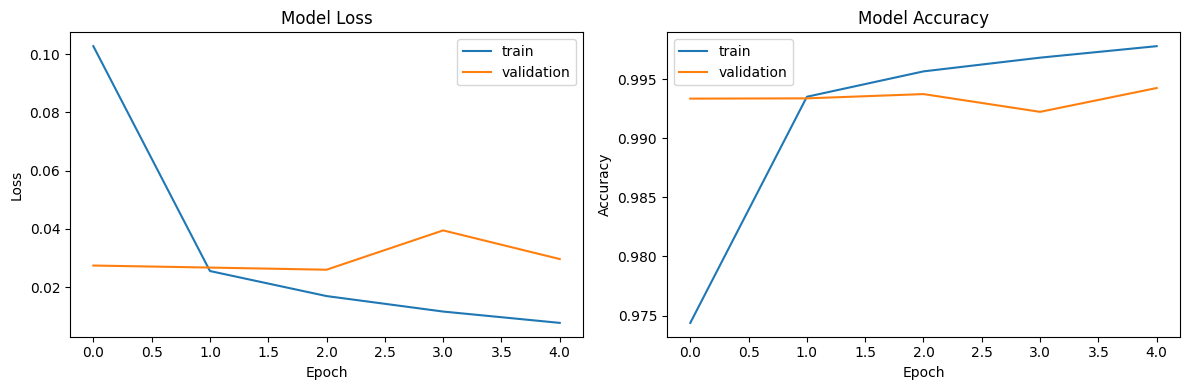

81/81 [==============================] - 73s 908ms/step - loss: 0.0404 - accuracy: 0.9922
Test Loss: 0.0404
Test Accuracy: 0.9922
Generating predictions for test data...
1/1 [==============================] - 0s 318ms/step

Classification Report:
              precision    recall  f1-score   support

         ADJ     0.9269    0.8960    0.9112      1924
         ADP     0.9788    0.9863    0.9825      2483
         ADV     0.9178    0.9402    0.9288      1187
         AUX     0.9524    0.9496    0.9510      1687
       CCONJ     0.9952    1.0000    0.9976       836
         DET     0.9878    0.9860    0.9869      2143
        INTJ     0.9240    0.8103    0.8634       195
        NOUN     0.9176    0.9741    0.9450      5020
         NUM     0.9443    0.9754    0.9596       487
        PART     0.8947    0.9813    0.9360       909
        PRON     0.9925    0.9688    0.9805      1633
       PROPN     0.9686    0.8321    0.8952      2597
       PUNCT     0.9864    0.9902    0.9883      3

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import conllu
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict
from transformers import TFBertModel, BertTokenizer
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# DATA LOADING AND PREPROCESSING
# ------------------------------------------------------------------
# Function to load and parse a CoNLL-U file
def load_conllu_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = conllu.parse(f.read())
    return data

# Load the train, dev, and test files (update the file paths as needed)
train_data = load_conllu_data('UD_English-GUM/en_gum-ud-train.conllu')
dev_data = load_conllu_data('UD_English-GUM/en_gum-ud-dev.conllu')
test_data = load_conllu_data('UD_English-GUM/en_gum-ud-test.conllu')

# Function to extract sentences and POS tags
def extract_sentences_and_tags(data):
    sentences = []
    pos_tags = []
    for sentence in data:
        words = [token['form'] for token in sentence]  # Keep original case for BERT
        tags = [token['upostag'] for token in sentence]
        sentences.append(words)
        pos_tags.append(tags)
    return sentences, pos_tags

# Extract words and POS tags from each dataset
train_sentences, train_pos_tags = extract_sentences_and_tags(train_data)
dev_sentences, dev_pos_tags = extract_sentences_and_tags(dev_data)
test_sentences, test_pos_tags = extract_sentences_and_tags(test_data)

# Build POS vocabulary with original tags
pos_vocab = {}
pos_vocab["<PAD>"] = 0  # Padding token

# Populate POS vocabulary
for tags in train_pos_tags:
    for tag in tags:
        if tag not in pos_vocab:
            pos_vocab[tag] = len(pos_vocab)

# Create reverse mapping for evaluation
id_to_pos = {v: k for k, v in pos_vocab.items()}

# Convert POS tags to IDs
def convert_tags_to_ids(pos_tags, pos_vocab):
    return [[pos_vocab[tag] for tag in tags] for tags in pos_tags]

# Convert datasets to numerical form (only for tags)
train_pos_tags_ids = convert_tags_to_ids(train_pos_tags, pos_vocab)
dev_pos_tags_ids = convert_tags_to_ids(dev_pos_tags, pos_vocab)
test_pos_tags_ids = convert_tags_to_ids(test_pos_tags, pos_vocab)

# ------------------------------------------------------------------
# BERT TOKENIZATION
# ------------------------------------------------------------------
# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
max_seq_length = 128  # Maximum sequence length for BERT

def tokenize_and_align_labels(sentences, pos_tags_ids):
    tokenized_inputs = []
    aligned_labels = []
    
    for sentence, tags in zip(sentences, pos_tags_ids):
        # Join the words to create a sentence
        sentence_text = ' '.join(sentence)
        
        # Tokenize the sentence
        bert_tokens = tokenizer.tokenize(sentence_text)
        if len(bert_tokens) > max_seq_length - 2:  # Account for [CLS] and [SEP]
            bert_tokens = bert_tokens[:max_seq_length - 2]
        
        # Map word-level tags to token-level tags
        word_idx = 0
        token_labels = []
        current_word = ''
        
        for token in bert_tokens:
            # Skip special tokens
            if token.startswith('##'):
                # This is a subword token, use the same tag as the main word
                if token_labels:
                    token_labels.append(token_labels[-1])
                continue
            
            # If we've processed all words or the current token doesn't match the beginning of the current word
            if word_idx >= len(sentence) or not sentence[word_idx].lower().startswith(token.replace('##', '').lower()):
                # Try to find a matching word
                found_match = False
                for i in range(word_idx, min(word_idx + 3, len(sentence))):
                    if sentence[i].lower().startswith(token.replace('##', '').lower()):
                        word_idx = i
                        found_match = True
                        break
                
                if not found_match:
                    # Use the previous tag or PAD if no previous tag
                    token_labels.append(token_labels[-1] if token_labels else pos_vocab["<PAD>"])
                    continue
            
            # Add the tag for this word
            token_labels.append(tags[word_idx])
            current_word = sentence[word_idx].lower()
            word_idx += 1
        
        # Ensure the length of token_labels matches the tokenized input after adding special tokens
        if len(token_labels) > max_seq_length - 2:
            token_labels = token_labels[:max_seq_length - 2]
        
        # Add [CLS] and [SEP] tokens in the labels
        token_labels = [pos_vocab["<PAD>"]] + token_labels + [pos_vocab["<PAD>"]]
        
        # Get the input_ids, token_type_ids, and attention_mask
        encoded = tokenizer.encode_plus(
            sentence_text,
            max_length=max_seq_length,
            padding='max_length',
            truncation=True,
            return_tensors='tf'
        )
        
        # Store the encoded features and aligned labels
        tokenized_inputs.append({
            'input_ids': encoded['input_ids'][0].numpy(),
            'attention_mask': encoded['attention_mask'][0].numpy(),
            'token_type_ids': encoded['token_type_ids'][0].numpy() if 'token_type_ids' in encoded else None
        })
        
        # Pad the labels to match the input length
        padded_labels = token_labels + [pos_vocab["<PAD>"]] * (max_seq_length - len(token_labels))
        aligned_labels.append(padded_labels)
    
    return tokenized_inputs, np.array(aligned_labels)

# Process datasets
print("Tokenizing and aligning train data...")
train_inputs, train_labels = tokenize_and_align_labels(train_sentences, train_pos_tags_ids)
print("Tokenizing and aligning dev data...")
dev_inputs, dev_labels = tokenize_and_align_labels(dev_sentences, dev_pos_tags_ids)
print("Tokenizing and aligning test data...")
test_inputs, test_labels = tokenize_and_align_labels(test_sentences, test_pos_tags_ids)

# Convert to TensorFlow datasets
def create_tf_dataset(inputs, labels, batch_size=16):
    input_ids = tf.convert_to_tensor([item['input_ids'] for item in inputs])
    attention_mask = tf.convert_to_tensor([item['attention_mask'] for item in inputs])
    
    if inputs[0]['token_type_ids'] is not None:
        token_type_ids = tf.convert_to_tensor([item['token_type_ids'] for item in inputs])
        dataset = tf.data.Dataset.from_tensor_slices(({
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'token_type_ids': token_type_ids
        }, labels))
    else:
        dataset = tf.data.Dataset.from_tensor_slices(({
            'input_ids': input_ids,
            'attention_mask': attention_mask
        }, labels))
    
    return dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# Create TensorFlow datasets
batch_size = 16
train_dataset = create_tf_dataset(train_inputs, train_labels, batch_size)
dev_dataset = create_tf_dataset(dev_inputs, dev_labels, batch_size)
test_dataset = create_tf_dataset(test_inputs, test_labels, batch_size)

# ------------------------------------------------------------------
# MODEL DEFINITION
# ------------------------------------------------------------------
def build_bert_pos_tagger(num_pos_tags):
    # Load pretrained BERT model
    bert = TFBertModel.from_pretrained('bert-base-cased')
    
    # Define input layers
    input_ids = Input(shape=(max_seq_length,), dtype=tf.int32, name='input_ids')
    attention_mask = Input(shape=(max_seq_length,), dtype=tf.int32, name='attention_mask')
    
    # Check if the model uses token_type_ids
    use_token_type_ids = 'token_type_ids' in tokenizer.model_input_names
    if use_token_type_ids:
        token_type_ids = Input(shape=(max_seq_length,), dtype=tf.int32, name='token_type_ids')
        bert_inputs = {'input_ids': input_ids, 'attention_mask': attention_mask, 'token_type_ids': token_type_ids}
    else:
        bert_inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}
    
    # Get BERT outputs
    bert_outputs = bert(bert_inputs)
    sequence_output = bert_outputs.last_hidden_state
    
    # Add dropout layer for regularization
    dropout = Dropout(0.1)(sequence_output)
    
    # POS tagging output layer
    outputs = Dense(num_pos_tags, activation='softmax')(dropout)
    
    # Create model
    if use_token_type_ids:
        model = Model(inputs=[input_ids, attention_mask, token_type_ids], outputs=outputs)
    else:
        model = Model(inputs=[input_ids, attention_mask], outputs=outputs)
    
    # Compile the model
    optimizer = Adam(learning_rate=3e-5)
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )
    
    return model

# Create the model
num_pos_tags = len(pos_vocab)
model = build_bert_pos_tagger(num_pos_tags)
model.summary()

# ------------------------------------------------------------------
# TRAIN THE MODEL
# ------------------------------------------------------------------
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('bert_pos_tagger.h5', monitor='val_loss', save_best_only=True)

# Train the model
epochs = 5
history = model.fit(
    train_dataset,
    validation_data=dev_dataset,
    epochs=epochs,
    callbacks=[early_stopping, model_checkpoint]
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('bert_pos_training_history.png')
plt.show()

# ------------------------------------------------------------------
# MODEL EVALUATION
# ------------------------------------------------------------------
# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Function to get predictions and true labels
def get_predictions_and_labels(dataset, model):
    all_preds = []
    all_labels = []
    
    for batch_inputs, batch_labels in dataset:
        # Get model predictions
        batch_preds = model.predict(batch_inputs)
        batch_preds = np.argmax(batch_preds, axis=-1)
        
        # Filter out padding tokens
        for i in range(len(batch_labels)):
            mask = batch_inputs['attention_mask'][i].numpy() == 1
            true_labels = batch_labels[i][mask].numpy()
            pred_labels = batch_preds[i][mask]
            
            # Skip [CLS] and [SEP] tokens which are 0 in our labels
            pred_labels = pred_labels[1:-1]
            true_labels = true_labels[1:-1]
            
            all_preds.extend(pred_labels)
            all_labels.extend(true_labels)
    
    return all_preds, all_labels

# Get predictions
print("Generating predictions for test data...")
test_preds, test_true = get_predictions_and_labels(test_dataset, model)

# Convert ID labels to POS tags
test_preds_tags = [id_to_pos[i] for i in test_preds]
test_true_tags = [id_to_pos[i] for i in test_true]

# Generate classification report
print("\nClassification Report:")
report = classification_report(
    y_true=test_true_tags,
    y_pred=test_preds_tags,
    digits=4
)
print(report)

# Save the report to a file
with open('bert_pos_classification_report.txt', 'w') as f:
    f.write(f"Test Loss: {test_loss:.4f}\n")
    f.write(f"Test Accuracy: {test_acc:.4f}\n\n")
    f.write("Classification Report:\n")
    f.write(report)

# Function to predict POS tags for a new sentence
def predict_pos_tags(sentence):
    # Tokenize the sentence
    encoded = tokenizer.encode_plus(
        sentence,
        max_length=max_seq_length,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )
    
    # Create input dictionary
    inputs = {
        'input_ids': encoded['input_ids'],
        'attention_mask': encoded['attention_mask']
    }
    if 'token_type_ids' in encoded:
        inputs['token_type_ids'] = encoded['token_type_ids']
    
    # Get predictions
    predictions = model.predict(inputs)
    predictions = np.argmax(predictions[0], axis=-1)
    
    # Filter to only get predictions for actual tokens (not padding)
    mask = encoded['attention_mask'][0].numpy() == 1
    token_predictions = predictions[mask][1:-1]  # Remove [CLS] and [SEP]
    
    # Get original tokens
    tokens = tokenizer.convert_ids_to_tokens(encoded['input_ids'][0].numpy()[mask][1:-1])
    
    # Convert prediction IDs to POS tags
    pos_tags = [id_to_pos[pred] for pred in token_predictions]
    
    return list(zip(tokens, pos_tags))

# Example usage
print("\nExample POS tagging prediction:")
example_sentence = "The quick brown fox jumps over the lazy dog."
tagged_tokens = predict_pos_tags(example_sentence)
print(f"Sentence: {example_sentence}")
print("Tokens and their predicted POS tags:")
for token, pos in tagged_tokens:
    print(f"{token}: {pos}")

Generating confusion matrix with raw counts...


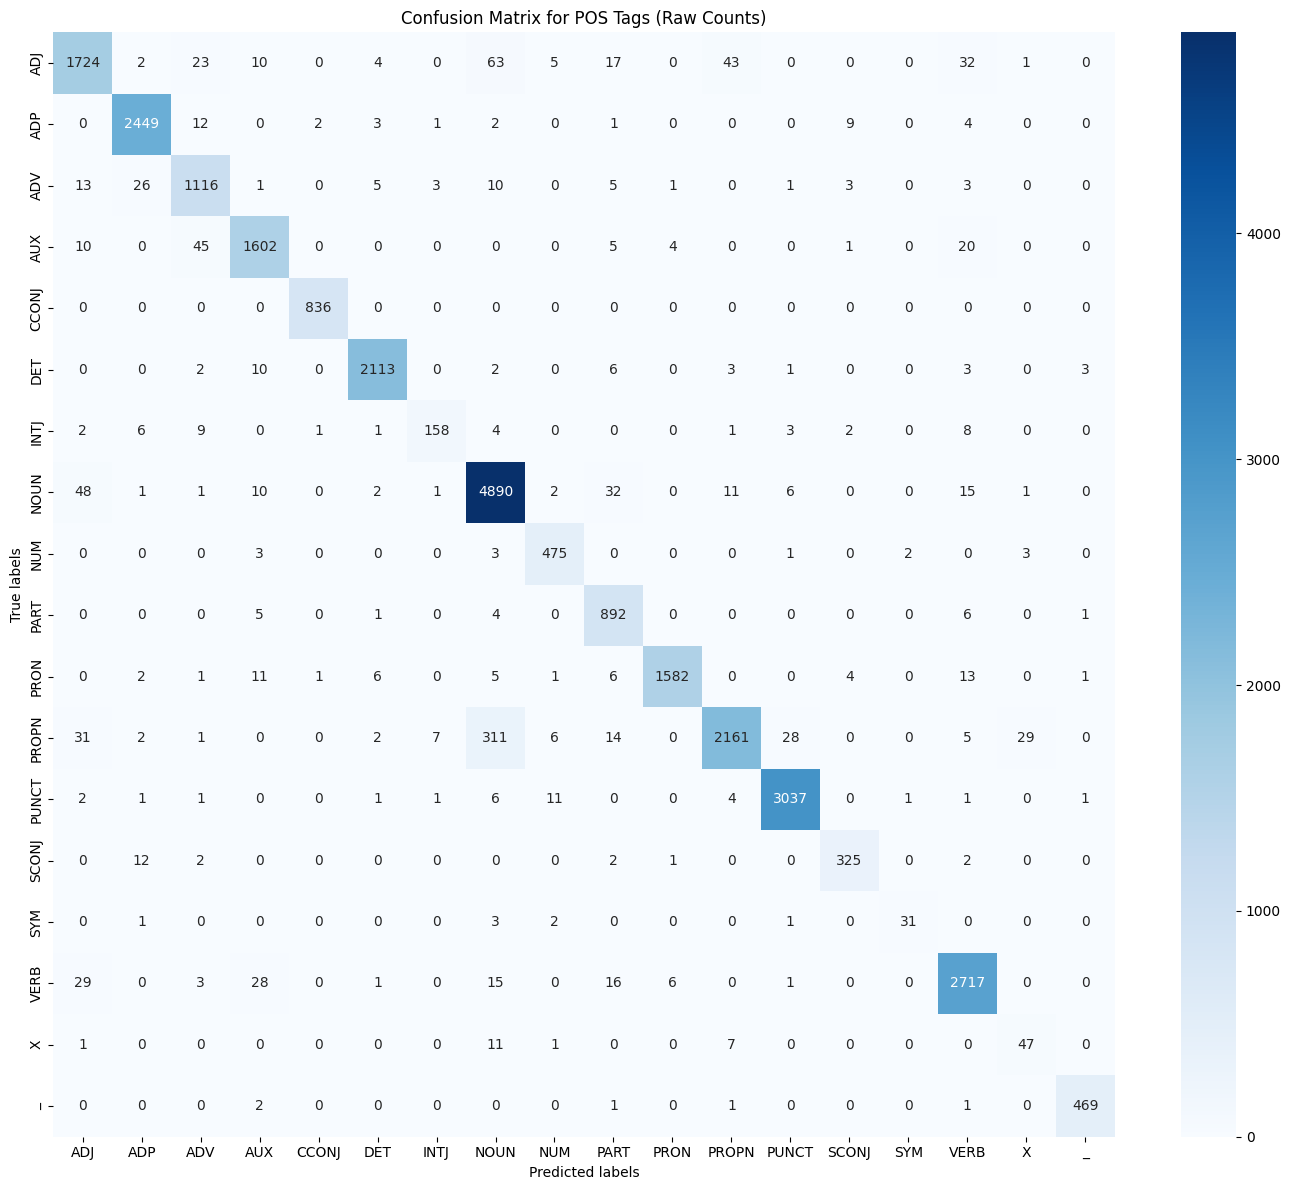


Top 10 Most Common POS Tagging Errors:
1. PROPN → NOUN: 311 occurrences
2. ADJ → NOUN: 63 occurrences
3. NOUN → ADJ: 48 occurrences
4. AUX → ADV: 45 occurrences
5. ADJ → PROPN: 43 occurrences
6. ADJ → VERB: 32 occurrences
7. NOUN → PART: 32 occurrences
8. PROPN → ADJ: 31 occurrences
9. VERB → ADJ: 29 occurrences
10. PROPN → X: 29 occurrences


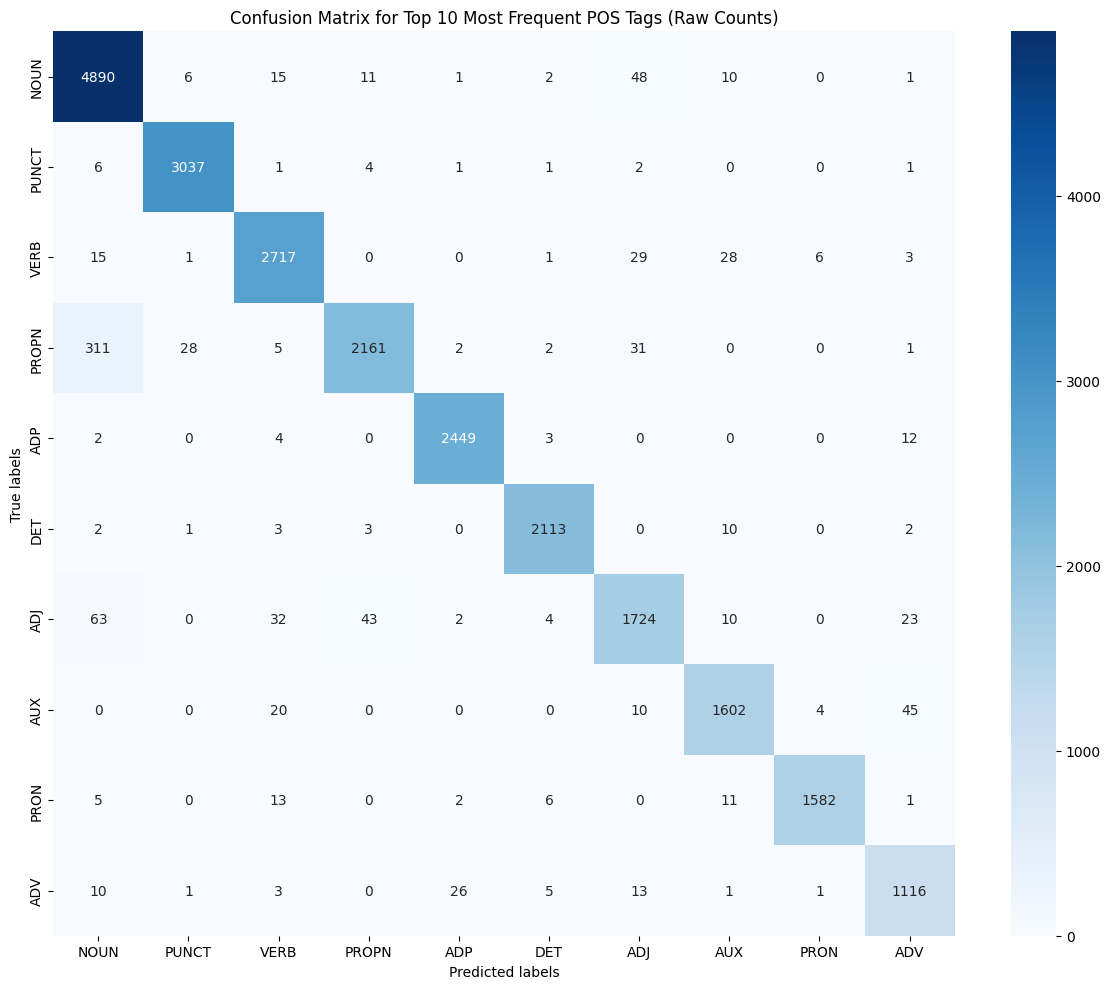


Per-class metrics for the most frequent POS tags:
POS Tag  Precision   Recall  F1-score  Support
   NOUN   0.917621 0.974104  0.945019     5020
  PUNCT   0.986359 0.990218  0.988285     3067
   VERB   0.960071 0.964844  0.962451     2816
  PROPN   0.968624 0.832114  0.895195     2597
    ADP   0.978817 0.986307  0.982548     2483
    DET   0.987845 0.986001  0.986922     2143
    ADJ   0.926882 0.896050  0.911205     1924
    AUX   0.952438 0.949615  0.951024     1687
   PRON   0.992472 0.968769  0.980477     1633
    ADV   0.917763 0.940185  0.928839     1187
   PART   0.894684 0.981298  0.935992      909
  CCONJ   0.995238 1.000000  0.997613      836
    NUM   0.944334 0.975359  0.959596      487
      _   0.987368 0.989451  0.988409      474
  SCONJ   0.944767 0.944767  0.944767      344

POS Tag Prediction Summary:
POS Tag  Total Count  Correct  Errors  Error Rate
   NOUN         5020     4890     130    0.025896
  PUNCT         3067     3037      30    0.009782
   VERB         28

In [ ]:
# Add this to the evaluation section of your previous code
from sklearn.metrics import confusion_matrix
import seaborn as sns

# After getting predictions and true labels
print("Generating confusion matrix with raw counts...")

# Get unique POS tags (sorted for better visualization)
unique_tags = sorted(list(set(test_true_tags)))

# Create the confusion matrix with raw counts
cm = confusion_matrix(test_true_tags, test_preds_tags, labels=unique_tags)

# Plot the raw confusion matrix
plt.figure(figsize=(14, 12))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',  # Use 'd' format for integers (raw counts)
    cmap='Blues',
    xticklabels=unique_tags,
    yticklabels=unique_tags
)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for POS Tags (Raw Counts)')
plt.tight_layout()
plt.savefig('bert_pos_confusion_matrix_raw.png', dpi=300)
plt.show()

# For a more detailed analysis, create a function to identify the most common errors
def analyze_errors(true_tags, pred_tags):
    error_counts = defaultdict(int)
    error_examples = defaultdict(list)
    
    for true, pred in zip(true_tags, pred_tags):
        if true != pred:
            error_pair = f"{true} → {pred}"
            error_counts[error_pair] += 1
    
    # Sort errors by frequency
    sorted_errors = sorted(error_counts.items(), key=lambda x: x[1], reverse=True)
    
    print("\nTop 10 Most Common POS Tagging Errors:")
    for i, (error_pair, count) in enumerate(sorted_errors[:10]):
        print(f"{i+1}. {error_pair}: {count} occurrences")
    
    return sorted_errors

# Run the error analysis
top_errors = analyze_errors(test_true_tags, test_preds_tags)

# Create a more compact confusion matrix for the most frequent tags using raw counts
def create_compact_confusion_matrix(true_tags, pred_tags, top_n=10):
    # Count occurrences of each tag
    tag_counts = defaultdict(int)
    for tag in true_tags:
        tag_counts[tag] += 1
    
    # Get the most frequent tags
    most_common_tags = sorted(tag_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]
    most_common_tags = [tag for tag, _ in most_common_tags]
    
    # Filter data to only include these tags
    filtered_indices = [i for i, tag in enumerate(true_tags) if tag in most_common_tags]
    filtered_true = [true_tags[i] for i in filtered_indices]
    filtered_pred = [pred_tags[i] for i in filtered_indices]
    
    # Create confusion matrix with raw counts
    cm = confusion_matrix(filtered_true, filtered_pred, labels=most_common_tags)
    
    # Plot raw counts
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',  # Use 'd' format for integers
        cmap='Blues',
        xticklabels=most_common_tags,
        yticklabels=most_common_tags
    )
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix for Top {top_n} Most Frequent POS Tags (Raw Counts)')
    plt.tight_layout()
    plt.savefig('bert_pos_top_tags_confusion_matrix_raw.png', dpi=300)
    plt.show()

# Create compact confusion matrix for the top 10 most frequent tags with raw counts
create_compact_confusion_matrix(test_true_tags, test_preds_tags, top_n=10)

# Calculate per-class metrics for a more detailed analysis
from sklearn.metrics import precision_recall_fscore_support

# Get per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(
    test_true_tags, 
    test_preds_tags, 
    labels=unique_tags, 
    average=None
)

# Create a DataFrame for better visualization
import pandas as pd
metrics_df = pd.DataFrame({
    'POS Tag': unique_tags,
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1,
    'Support': support
})

# Sort by support (frequency) in descending order
metrics_df = metrics_df.sort_values('Support', ascending=False)

# Print the top 15 tags by frequency
print("\nPer-class metrics for the most frequent POS tags:")
print(metrics_df.head(15).to_string(index=False))

# Save the full metrics table
metrics_df.to_csv('bert_pos_per_class_metrics.csv', index=False)

# Generate raw count diagonal values and error rates
diag_values = np.diag(cm)
row_sums = np.sum(cm, axis=1)
error_counts = row_sums - diag_values
error_rates = error_counts / row_sums

# Create a summary dataframe with counts and error rates
summary_df = pd.DataFrame({
    'POS Tag': unique_tags,
    'Total Count': row_sums,
    'Correct': diag_values,
    'Errors': error_counts,
    'Error Rate': error_rates
})

# Sort by frequency
summary_df = summary_df.sort_values('Total Count', ascending=False)

# Print and save summary
print("\nPOS Tag Prediction Summary:")
print(summary_df.head(15).to_string(index=False))
summary_df.to_csv('bert_pos_prediction_summary.csv', index=False)

# Create a table for the most common errors
error_df = pd.DataFrame(top_errors[:20], columns=['Error Type', 'Count'])
error_df.to_csv('bert_pos_common_errors.csv', index=False)
print("\nSaved top 20 most common errors to 'bert_pos_common_errors.csv'")

| Method                         | Accuracy     | Weighted F1-Score | Macro F1-Score | Notes                                                                   |
| :----------------------------- | :----------- | :---------------- | :------------- | :---------------------------------------------------------------------- |
| Baseline Rule-Based            | 85.88%       | 0.85              | 0.80           | Simple frequency-based tagging (Test Set).                                |
| Enhanced Rule-Based            | 86.82%       | 0.86              | 0.81           | Added suffix/prefix rules (Test Set).                                     |
| CRF (Best Tuned)               | 93.17%       | 0.93              | 0.90           | `c1=0.005`, `c2=0.1`, `max_iter=100` (Test Set).                           |
| BiLSTM-CRF (PyTorch)           | 90.58%       | 0.92*             | 0.85*          | *F1 re-calc. from test eval output. Showed overfitting (Test Set).        |
| BiLSTM-CRF (TF + 5-Fold CV)    | 92.11%**     | 0.93**            | 0.87**         | **Evaluated on Dev Set after CV (Test evaluation not shown in notebook).  |
| **BERT (TF, fine-tuned)**      | **99.22%**   | **0.99**        | **0.97**       | `bert-base-cased`, fine-tuned 5 epochs (Test Set). Best performance.      |